In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%reload_ext autoreload
%autoreload 2

import warnings

from contrib.handcrafted_data import syn_dataset
from contrib.differentiable_rendering.sigmoids_renderer.renderer import Renderer
from utils import (
    SyntheticPatch, LinePerturbationPipe, LineRandomShift, LineClip,
    compute_pixel_coords, compute_pixel_density, get_pixel_coords_and_density, wrap_lines_into_numpy_batch,
    torch_to_synthetic_lines
)
from stateful_optimizer import (
    StatefulAligner, 
    LossComposition, 
    make_simple_aligner,
    make_default_loss_fn,
    store_render_difference, 
    store_grads, 
    save_best_batch
)
from crossing_refiner import CrossingRefinerFull
# from optimize import optimize_line_batch

from matplotlib import pyplot as plt
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from vectran.data.graphics_primitives import PrimitiveType
import numpy as np
import torch

torch.manual_seed(4)
np.random.seed(4)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

## Train a neural network for crossings inference

In [2]:
warnings.filterwarnings("ignore")
data = [syn_dataset[i] for i in range(10000)]

In [3]:
for i, sample in enumerate(data):
    data[i]['raster'] = 1 - sample['raster']
    vectors = sample['vector'][PrimitiveType.PT_LINE]
    vectors = vectors[vectors.sum(axis=1) != 0][:, :5]
    data[i]['crossing_raster'] = SyntheticPatch.from_lines(vectors, default_line_rgba=(1., 1., 1., 0.5)).get_image()
    data[i]['crossing_raster'] /= np.max(sample['crossing_raster'])

In [4]:
model = CrossingRefinerFull().to(DEVICE)
model.train(True)
bce = torch.nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([1.0]).to(DEVICE))
mse = torch.nn.MSELoss()
l1_loss = torch.nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

dataloader = DataLoader(data, 64, True)
for epoch in range(50):
    for batch in tqdm(dataloader):
        raster = batch['raster'].unsqueeze(dim=1).float().to(DEVICE)
        crossing_raster = batch['crossing_raster'].unsqueeze(dim=1).float().to(DEVICE)

        pred = model.forward(raster)
        loss = l1_loss(pred, crossing_raster) + 0.5 * bce(pred, crossing_raster)
        diff = crossing_raster - pred
#         loss += 0.1 * torch.mean(torch.abs(diff) * torch.relu(diff))
#         loss += torch.abs((torch.max(crossing_raster) - torch.min(crossing_raster)) - (torch.max(crossing_raster) - torch.min(crossing_raster)))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 157/157 [00:03<00:00, 42.60it/s]


## Try the new aligner

209.0879669189453


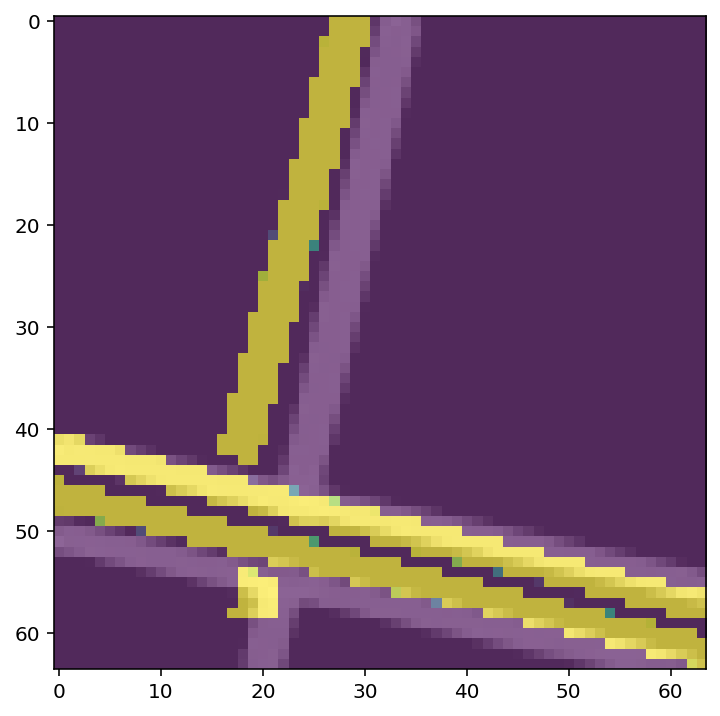

162.13958740234375


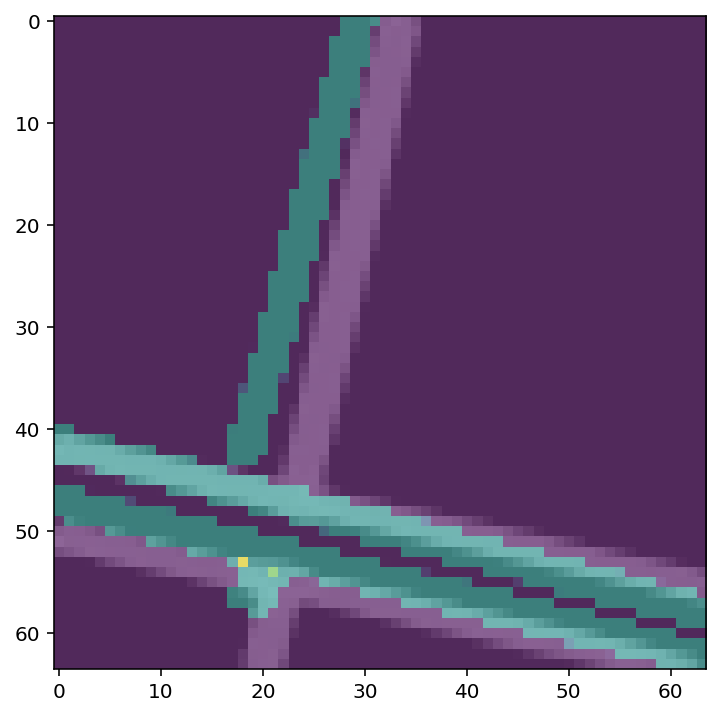

149.55657958984375


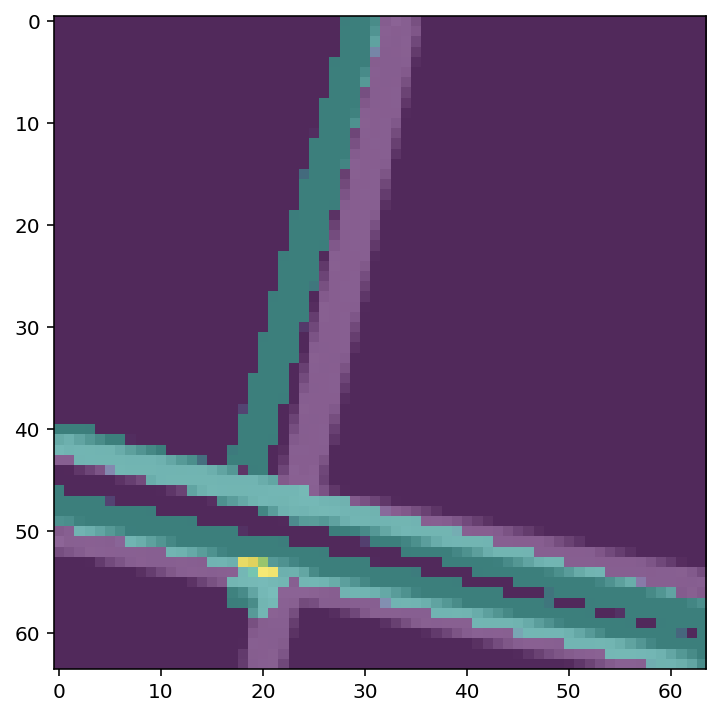

153.8981475830078


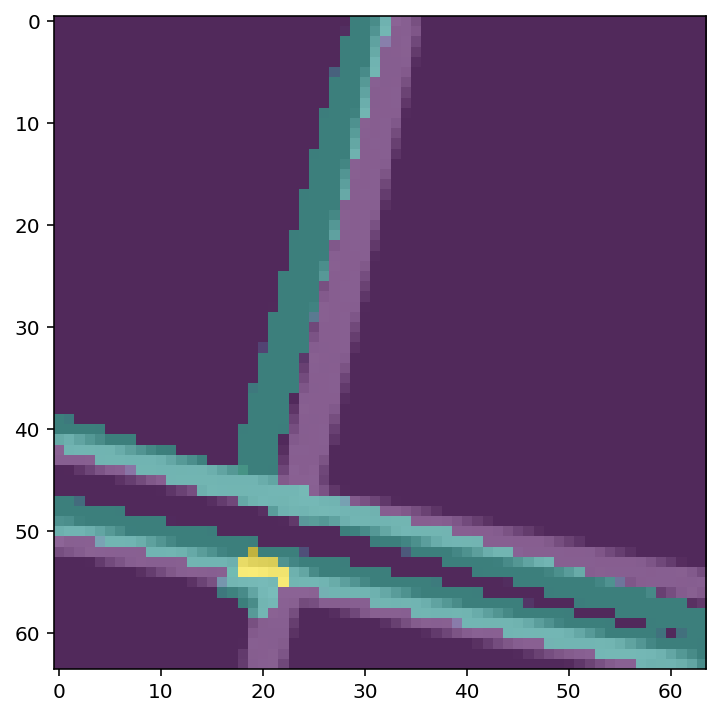

166.54515075683594


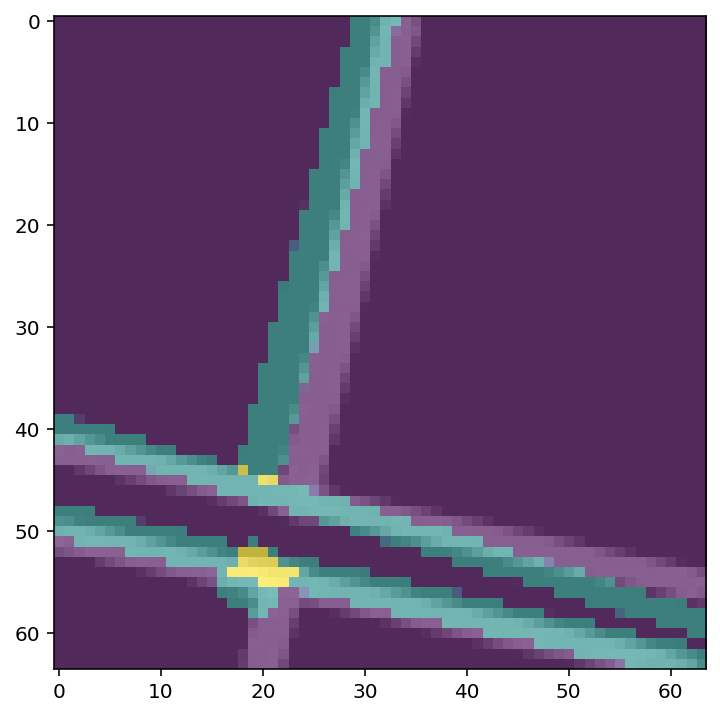

171.73968505859375


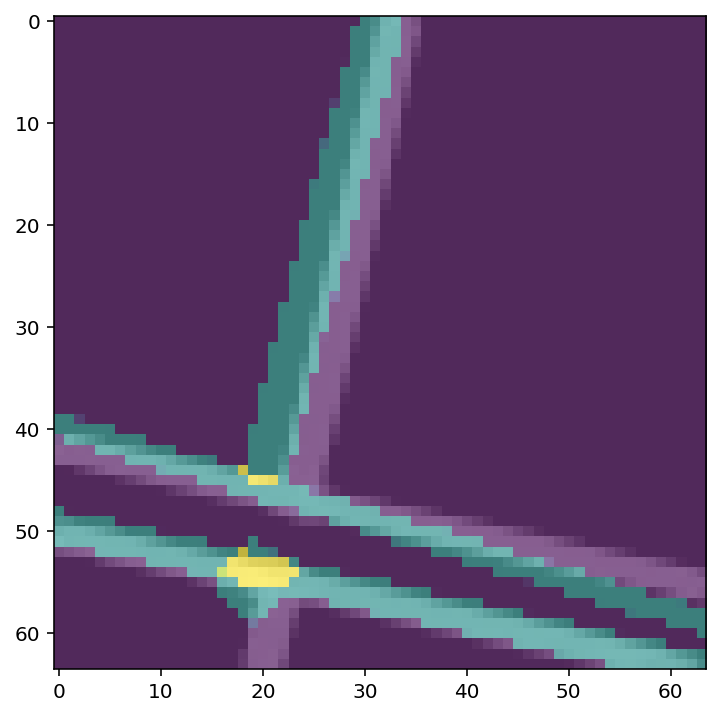

173.97604370117188


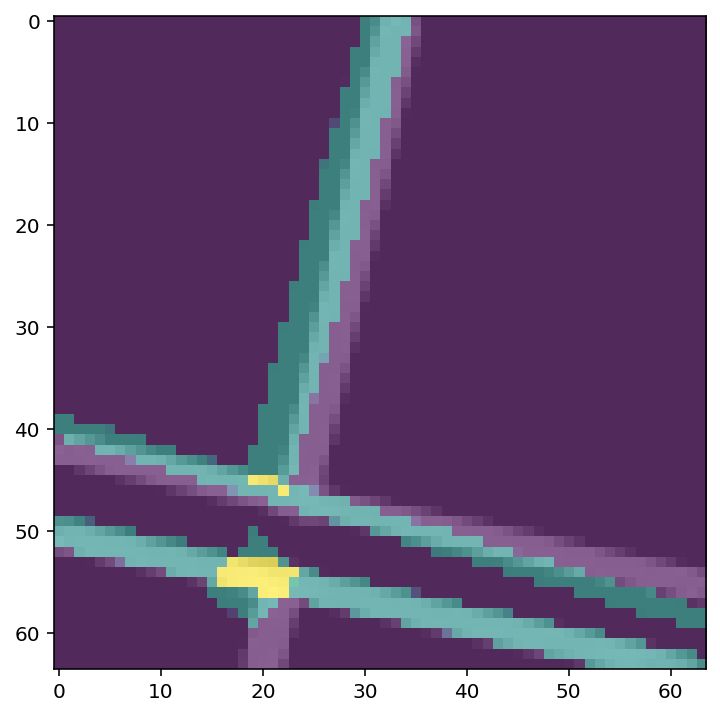

166.1306610107422


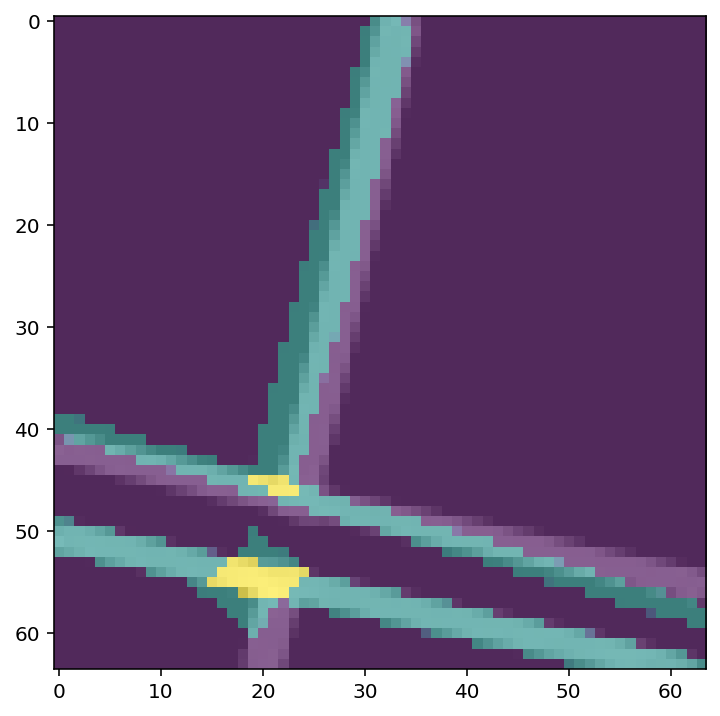

148.28599548339844


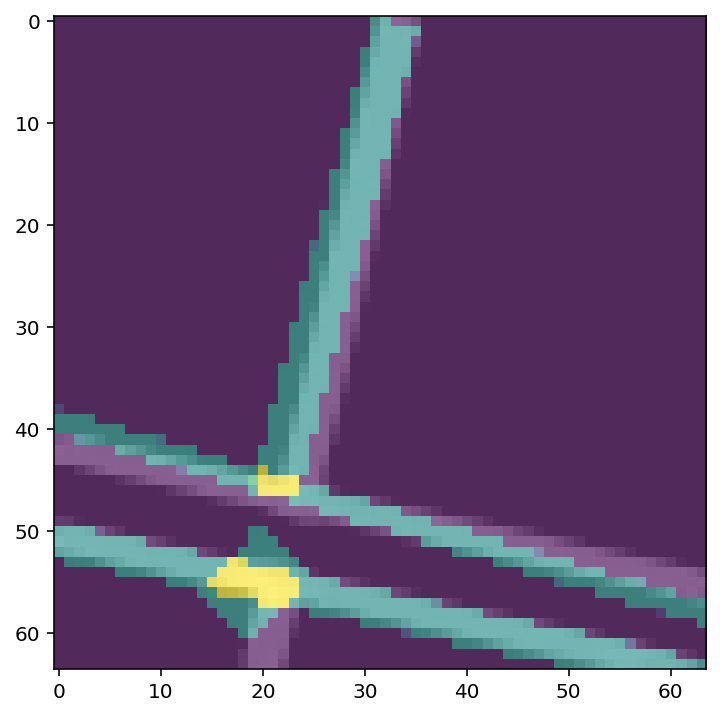

133.1200714111328


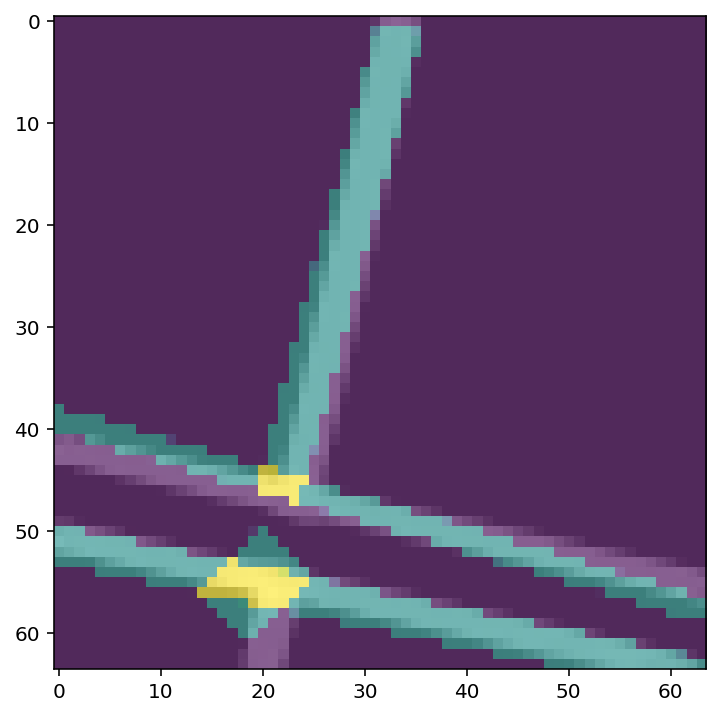

109.98289489746094


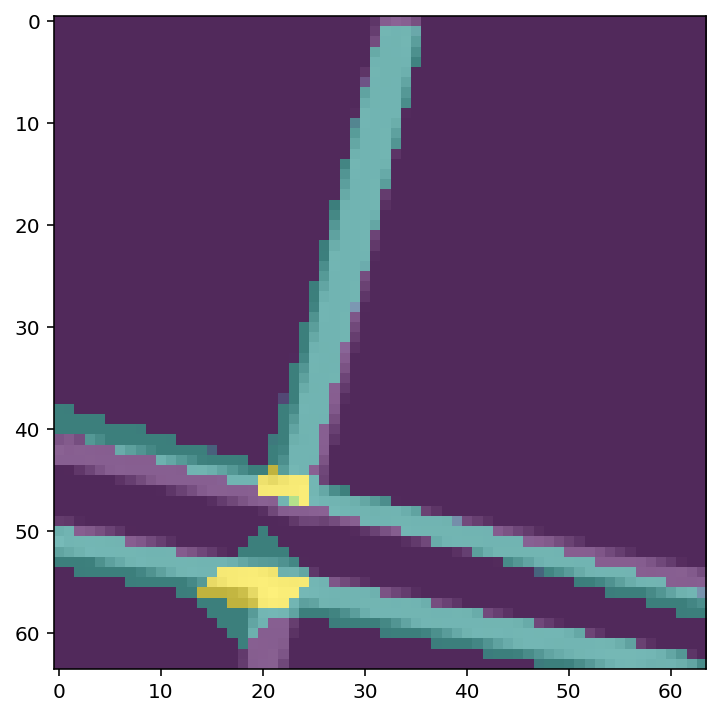

84.5774917602539


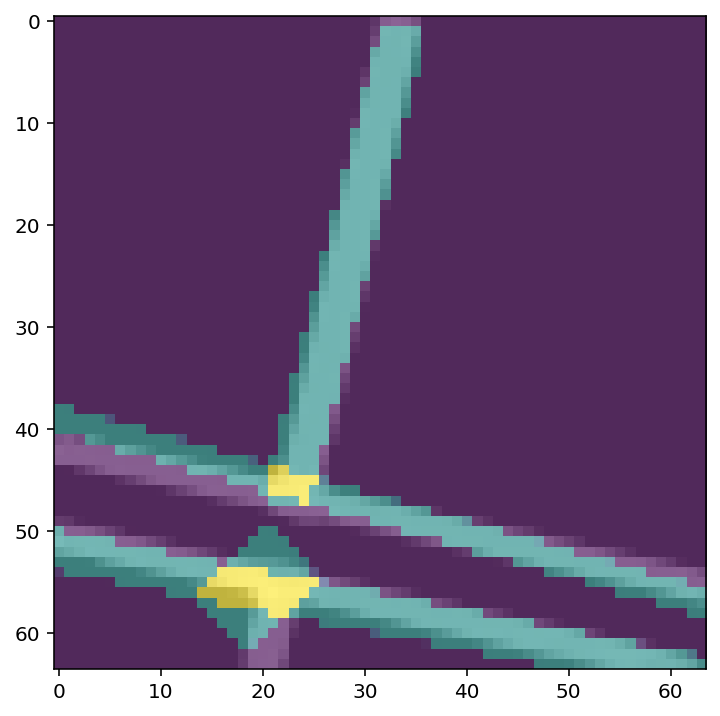

83.0499267578125


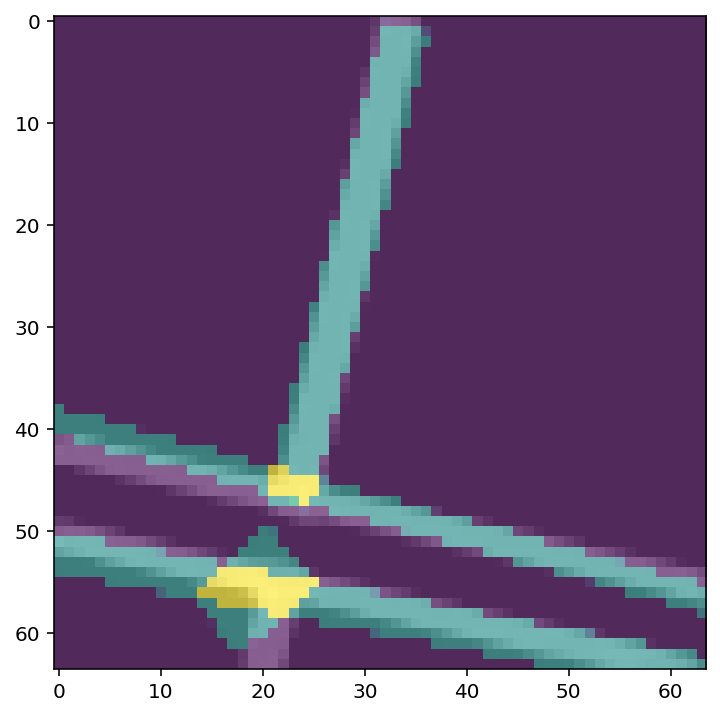

82.35503387451172


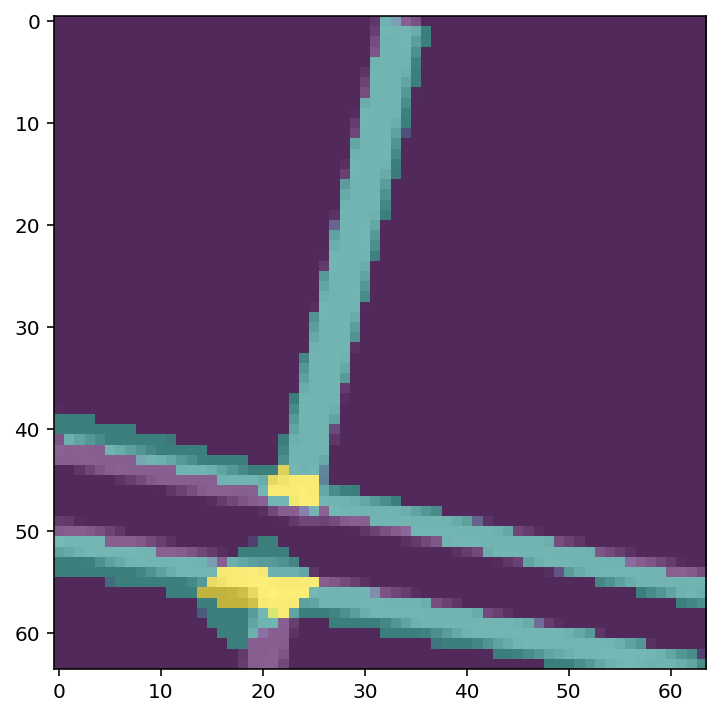

87.60309600830078


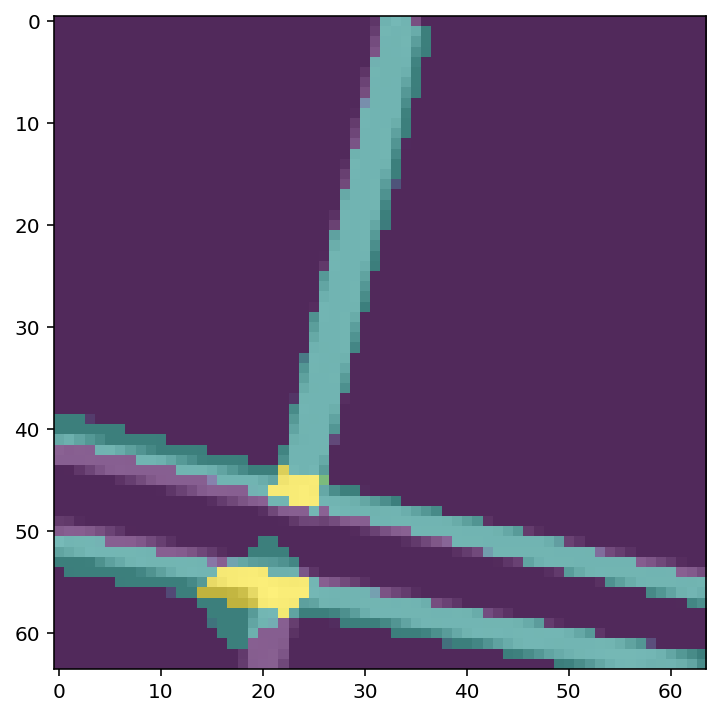

94.76496887207031


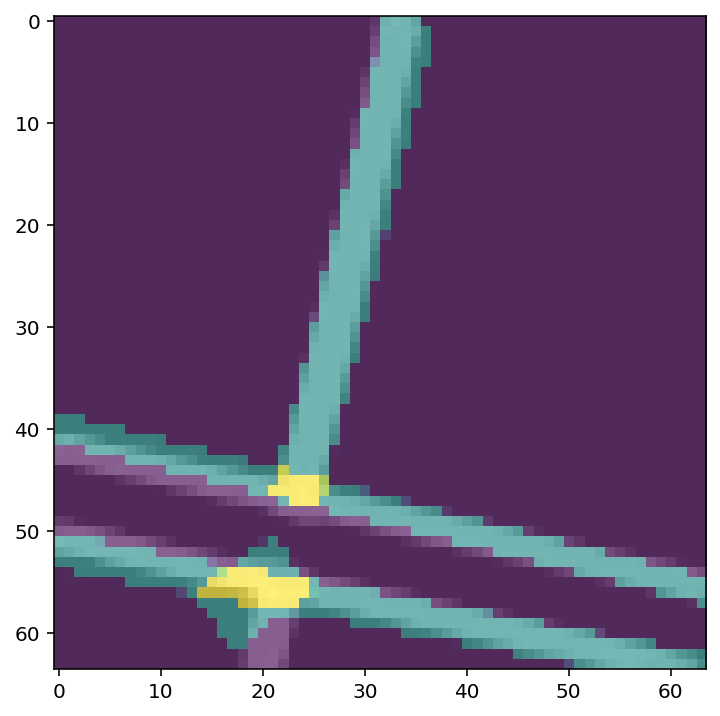

99.10850524902344


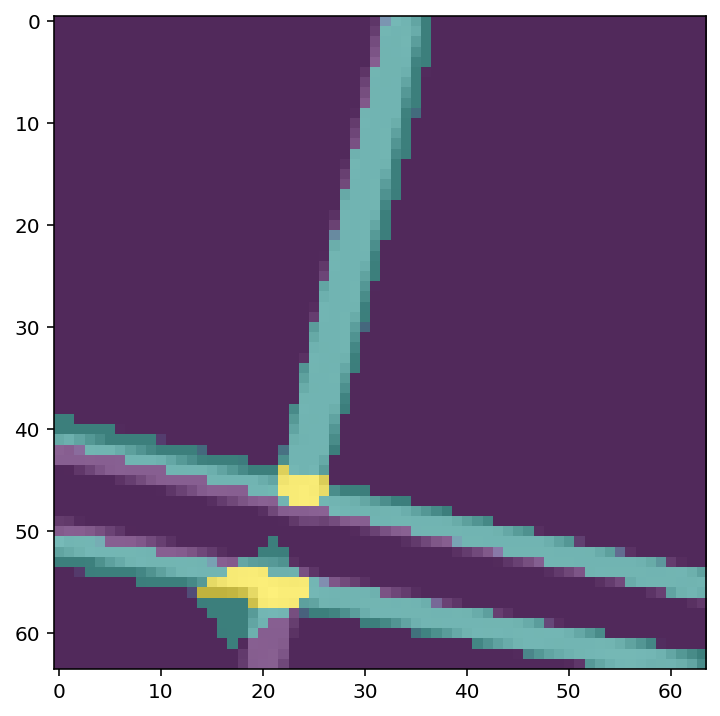

98.7279052734375


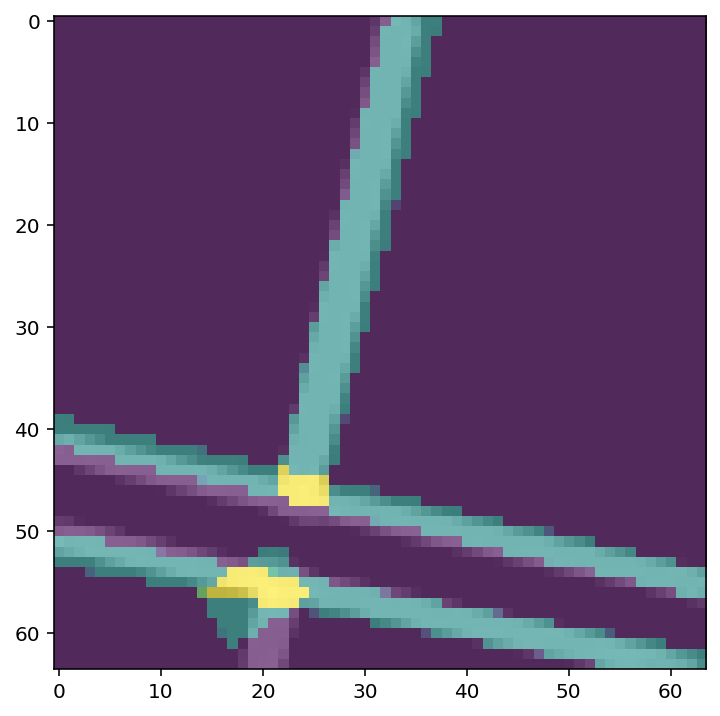

87.13859558105469


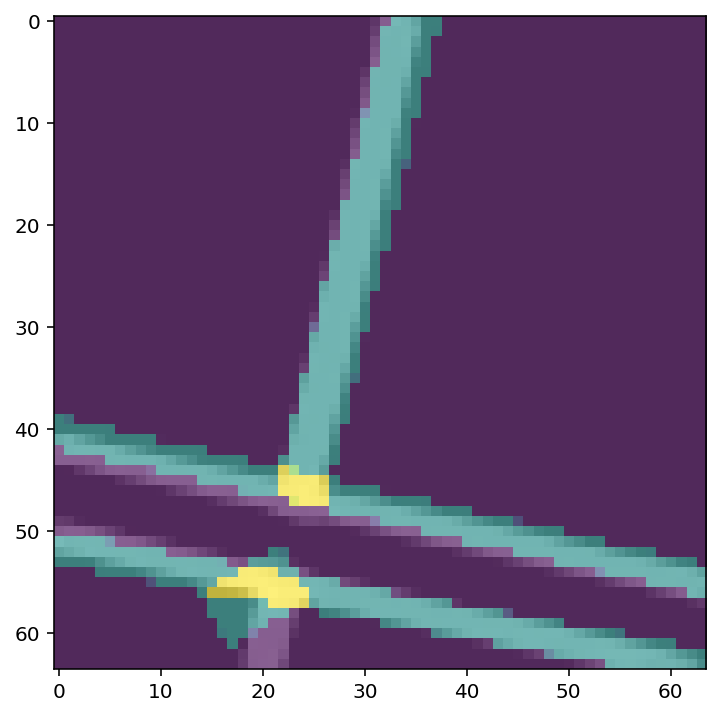

74.3368911743164


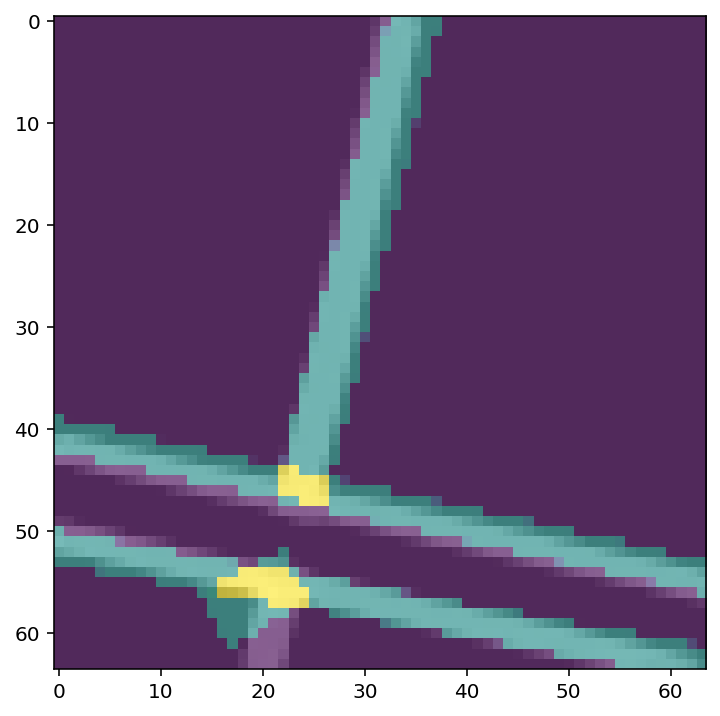

59.4253044128418


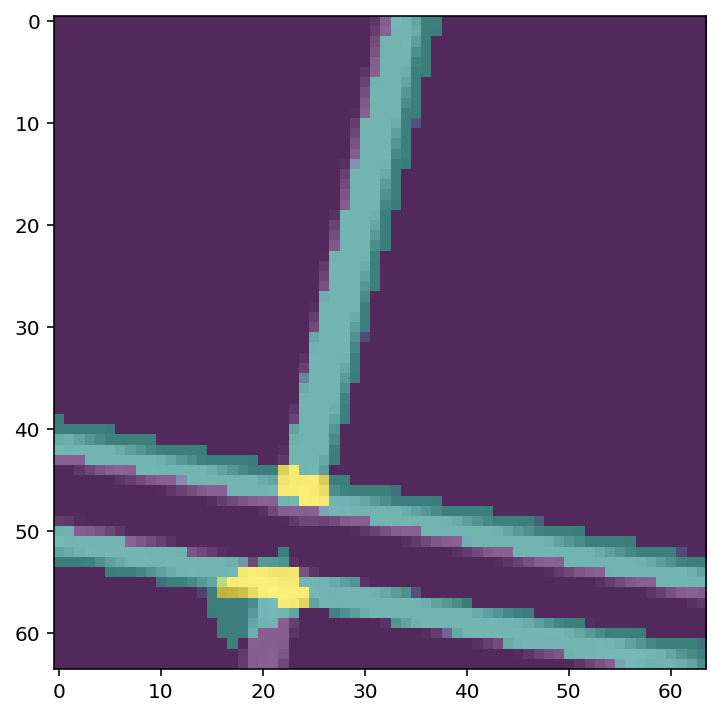

54.15272903442383


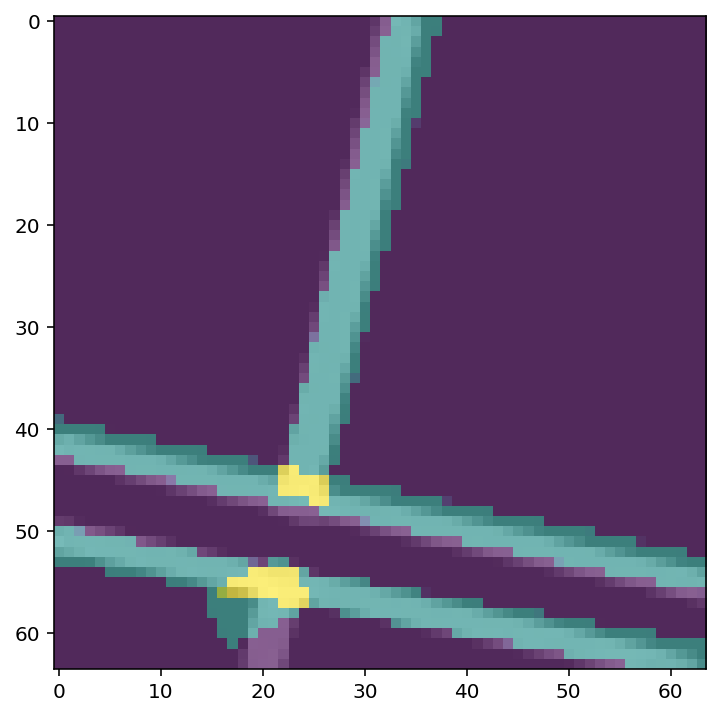

43.901607513427734


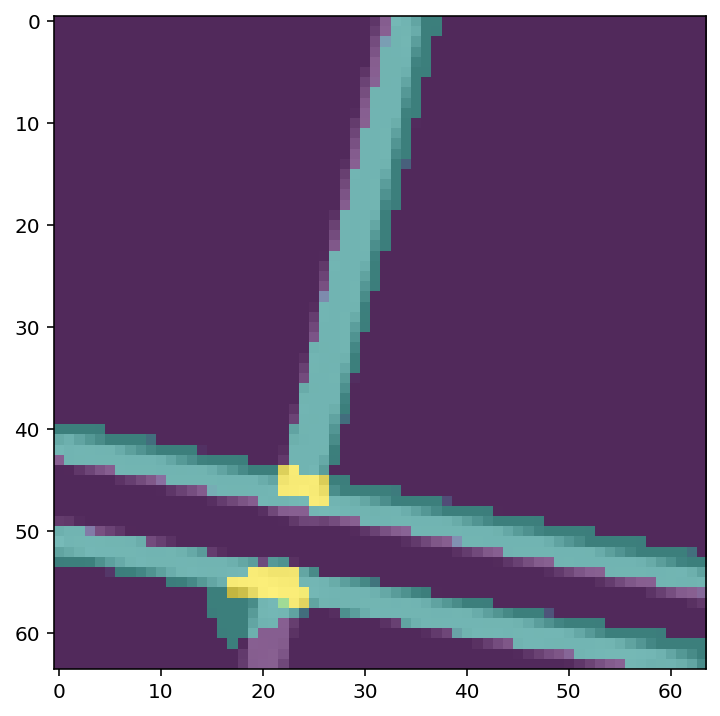

38.22050857543945


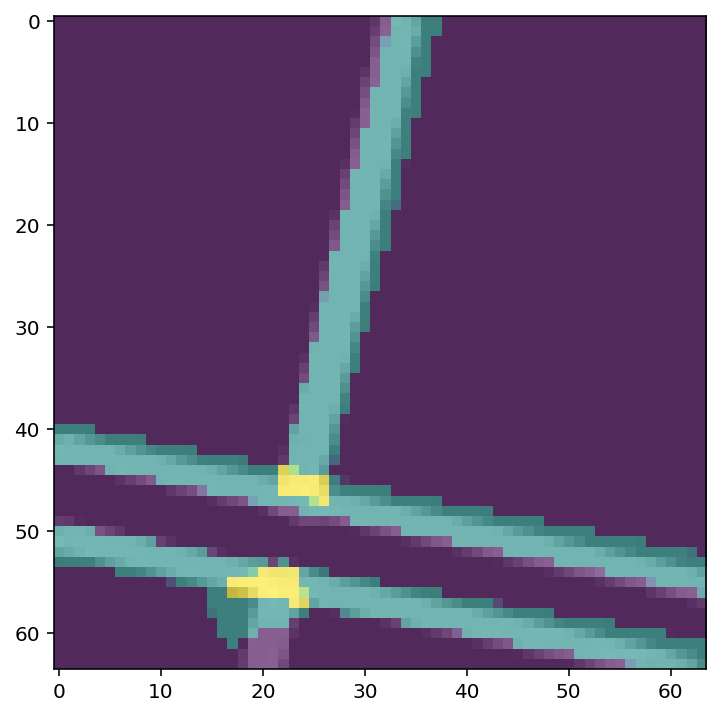

39.665260314941406


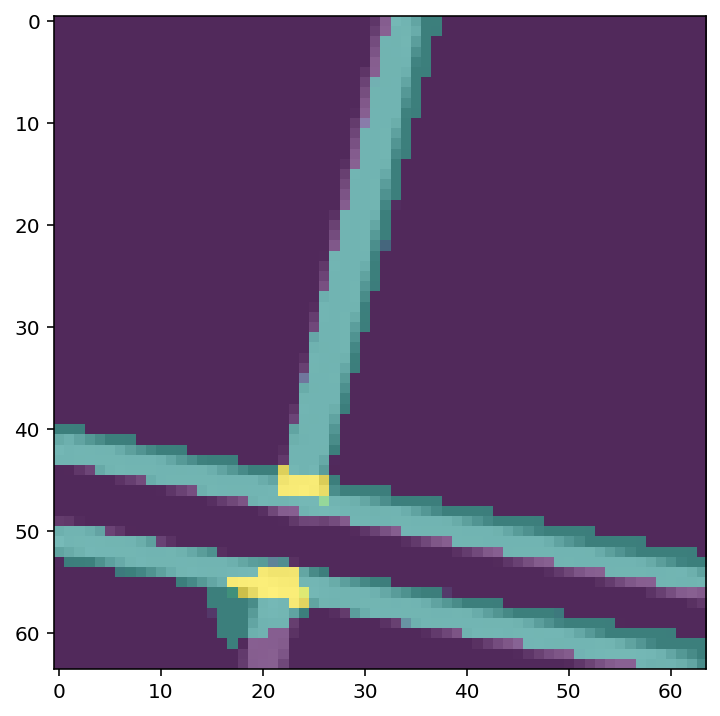

37.388206481933594


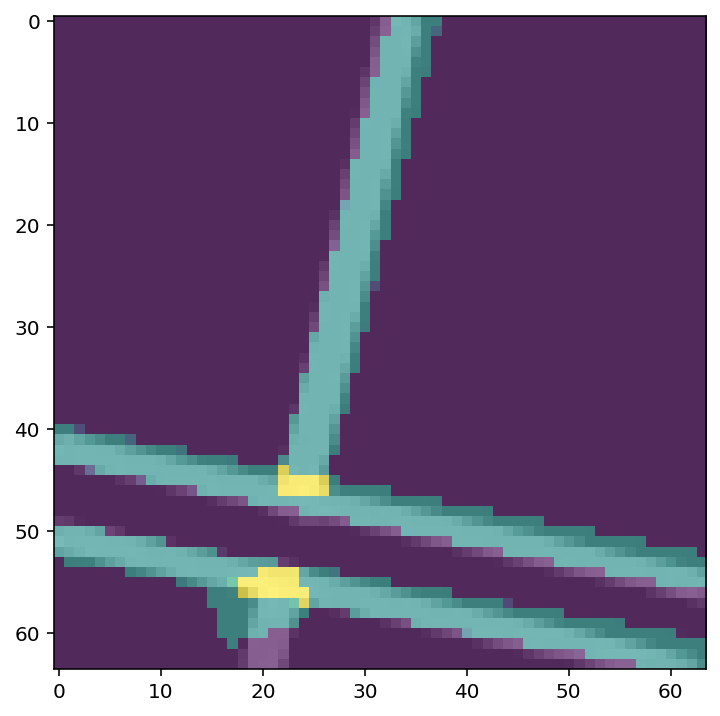

35.51532745361328


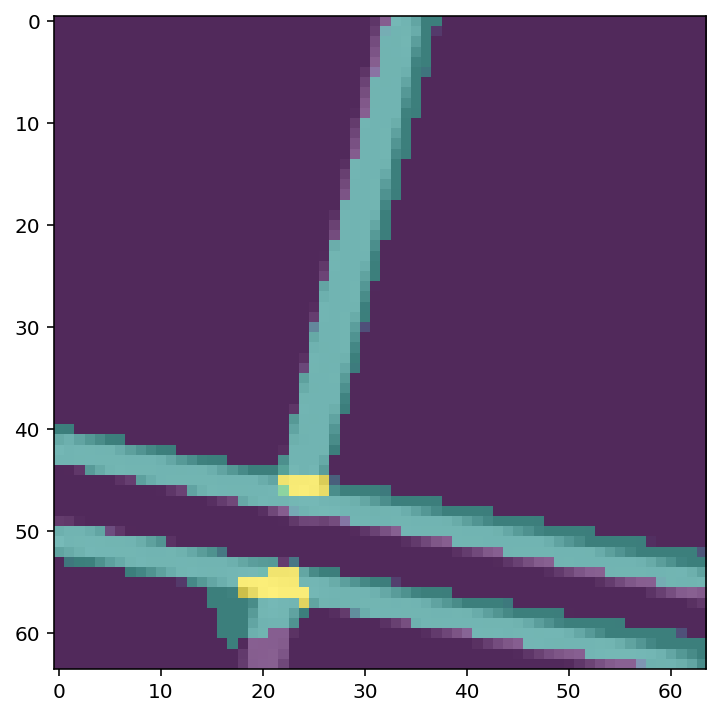

37.07578659057617


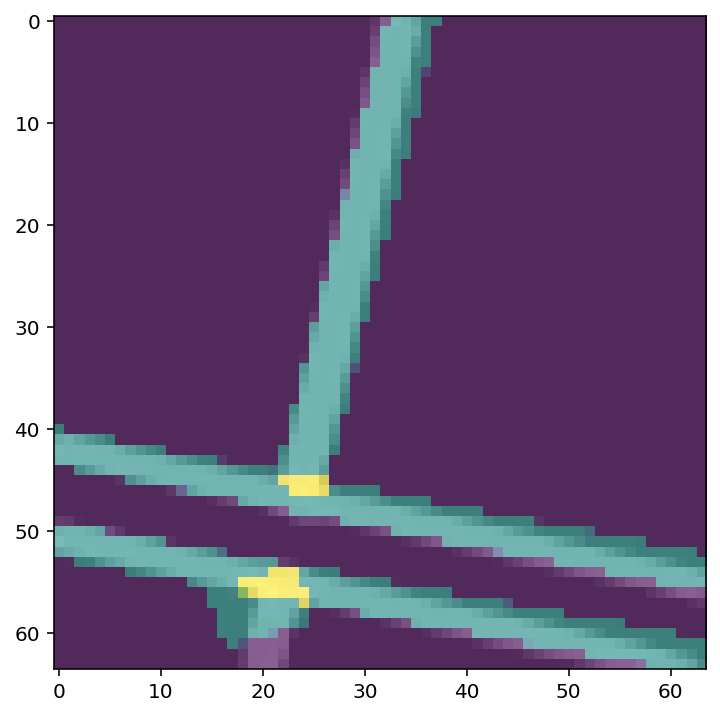

39.94165802001953


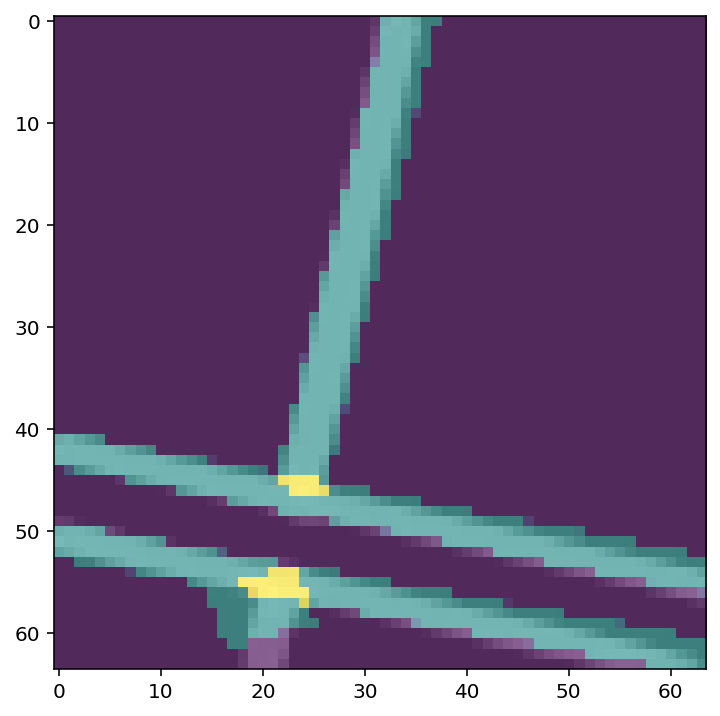

40.20016098022461


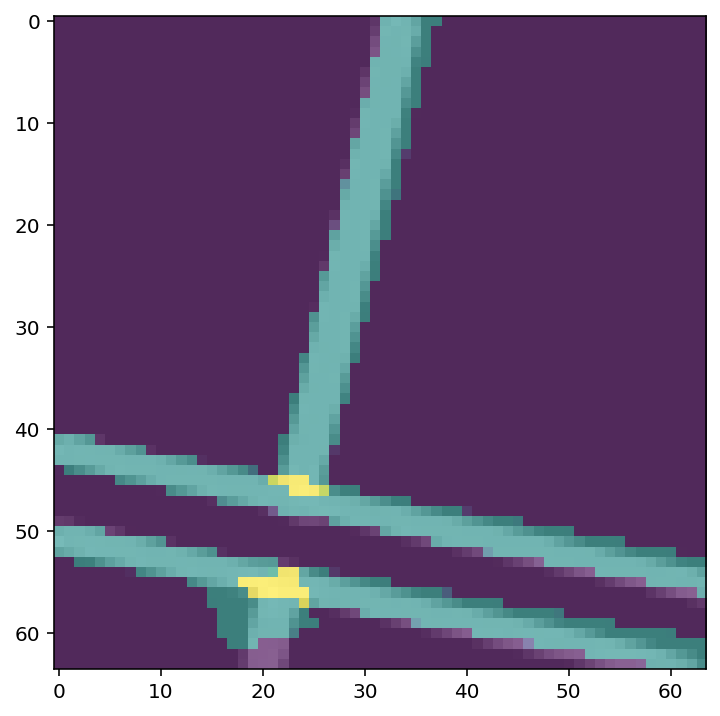

39.8848762512207


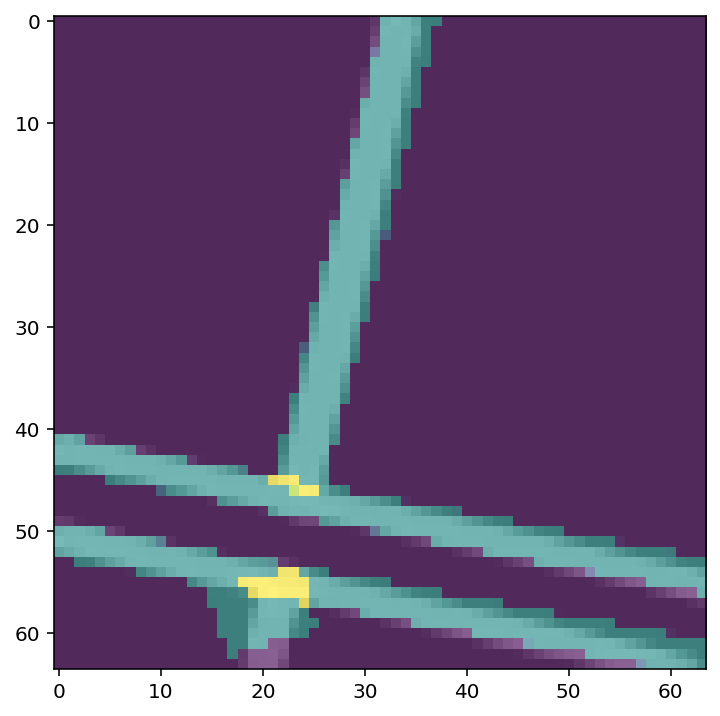

39.48993682861328


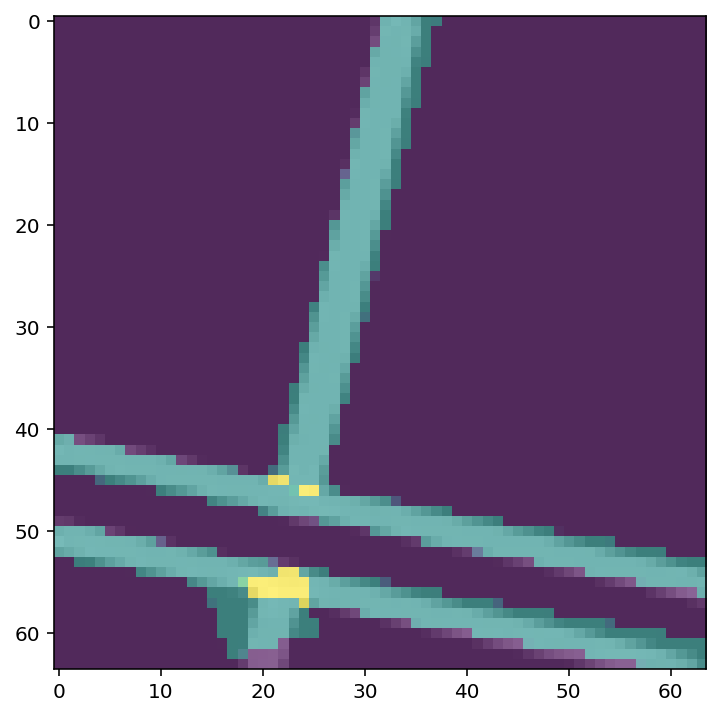

43.027957916259766


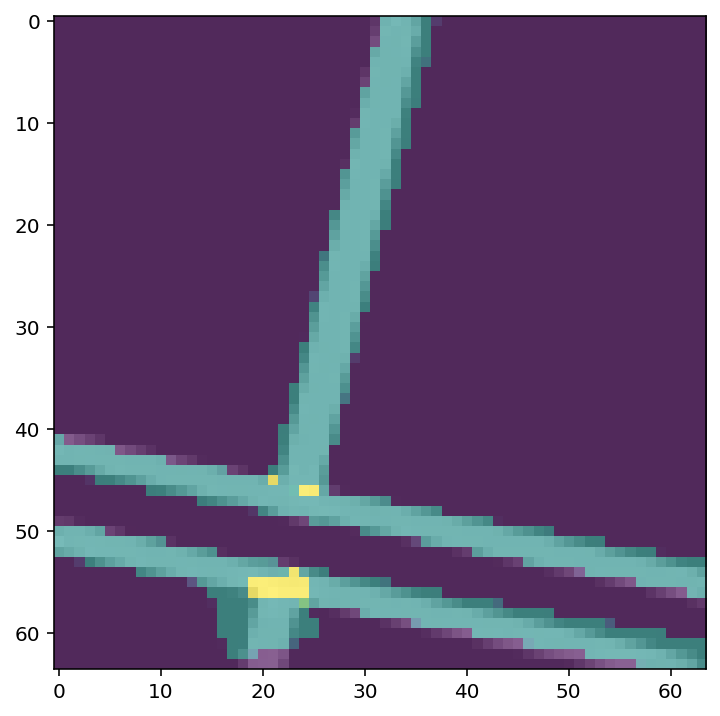

40.921409606933594


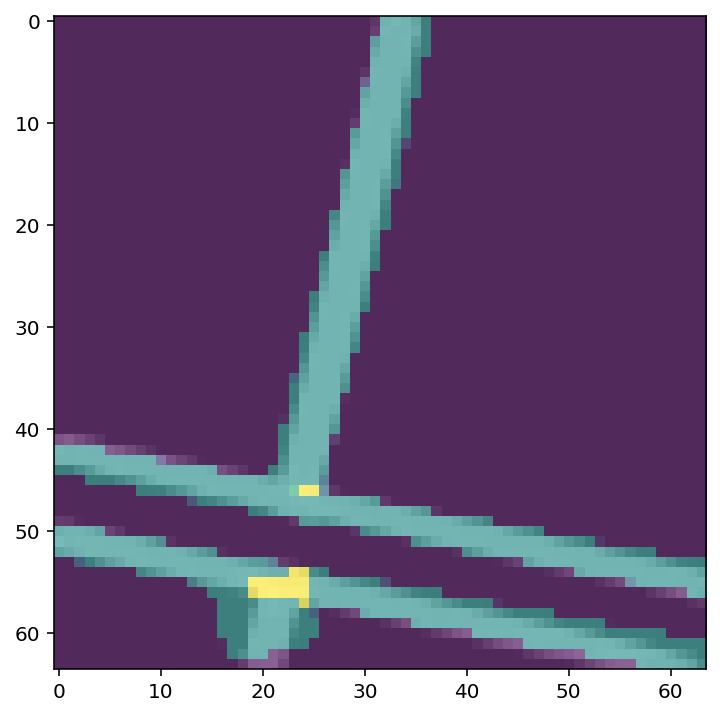

34.779911041259766


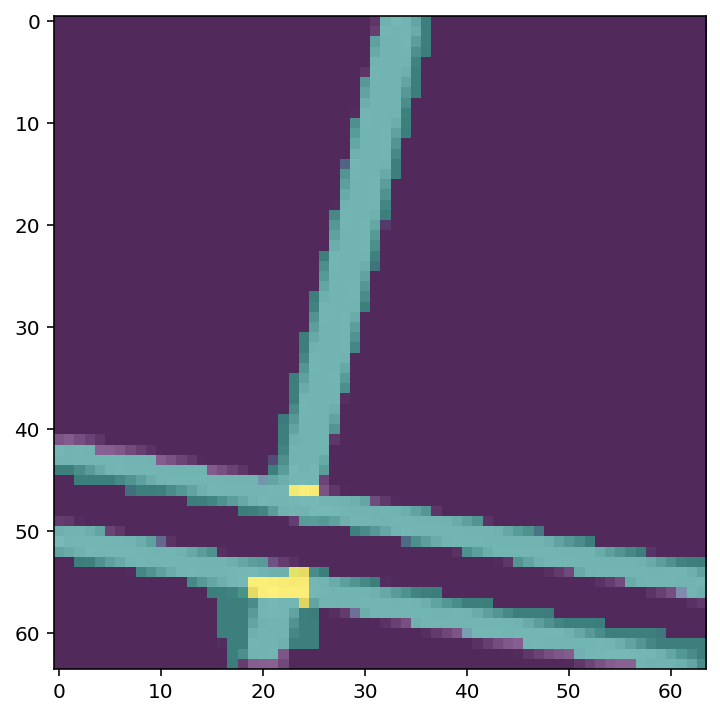

31.758193969726562


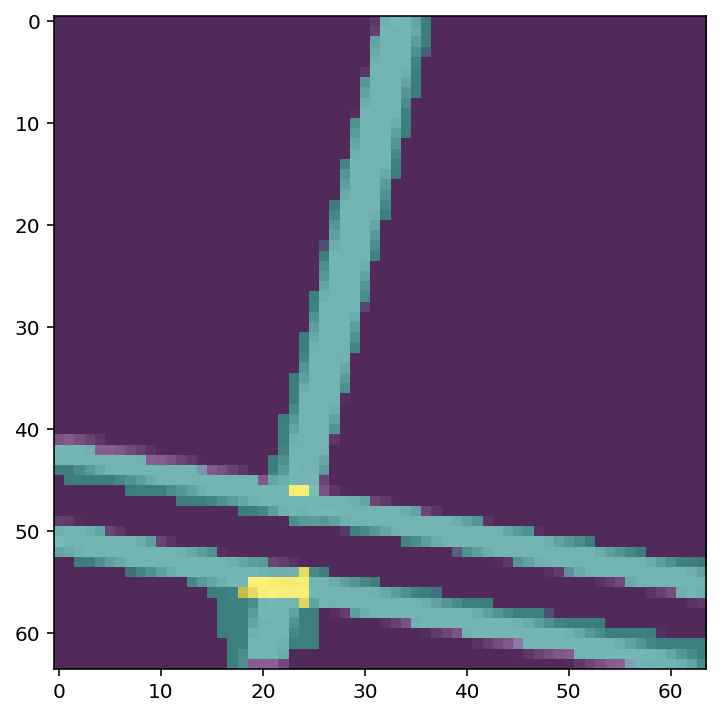

30.255861282348633


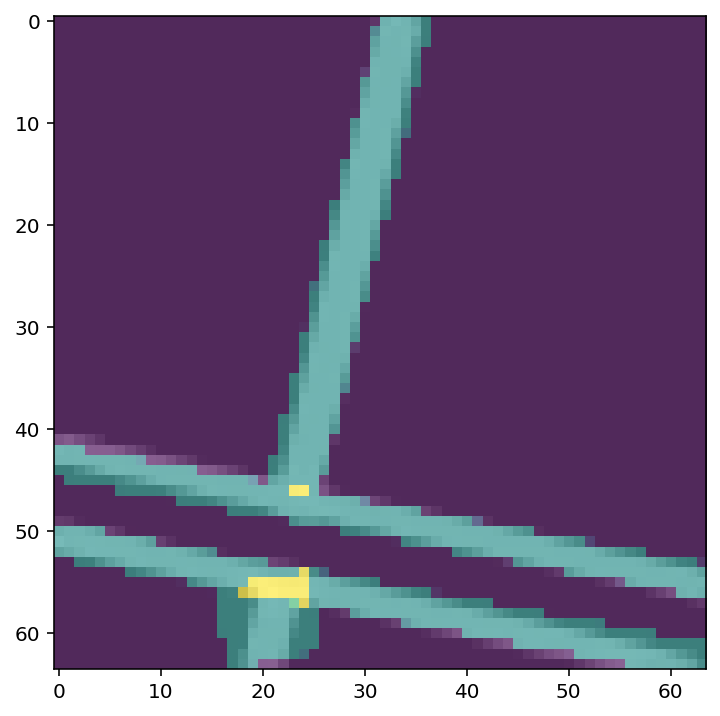

27.65383529663086


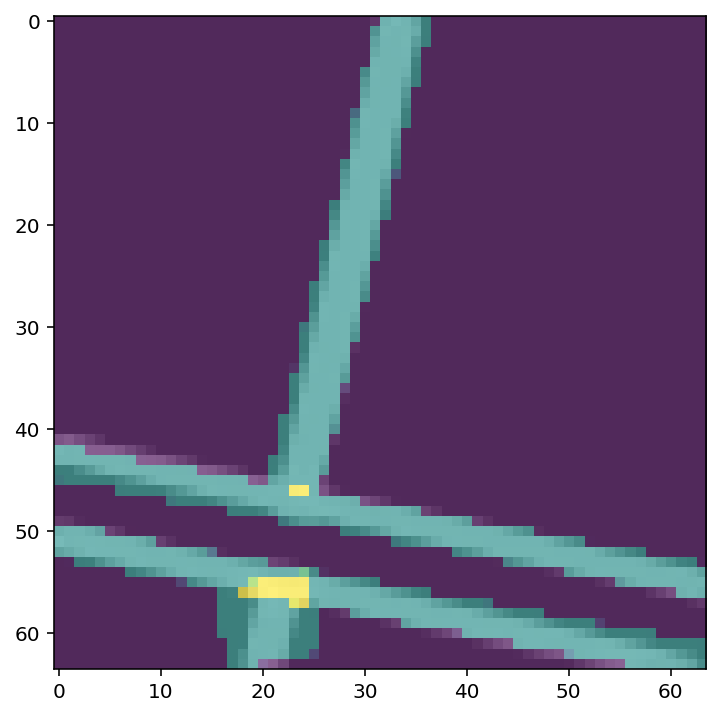

26.359233856201172


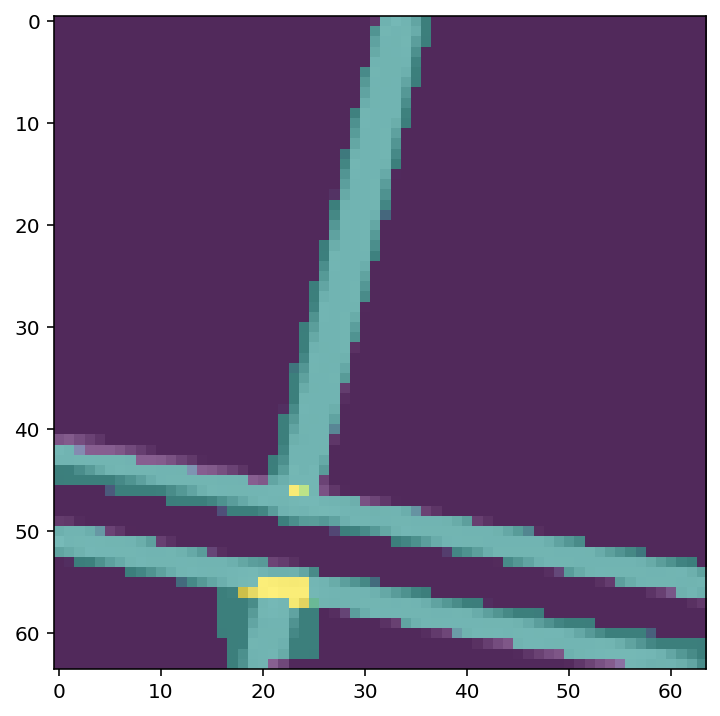

23.235424041748047


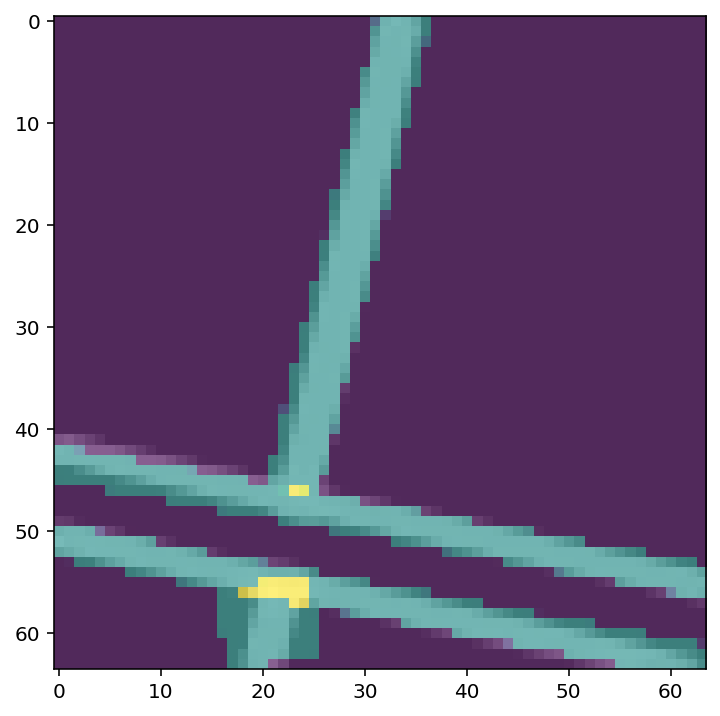

22.94373321533203


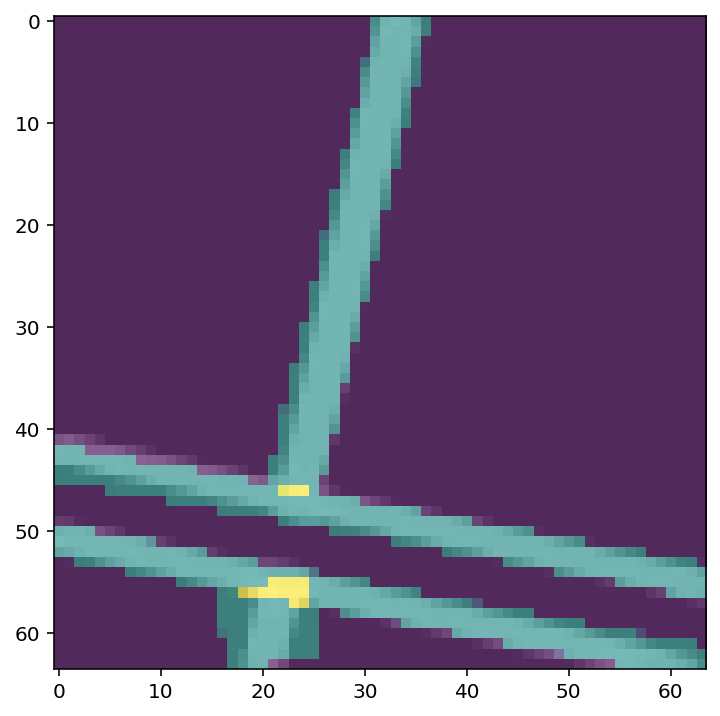

19.796672821044922


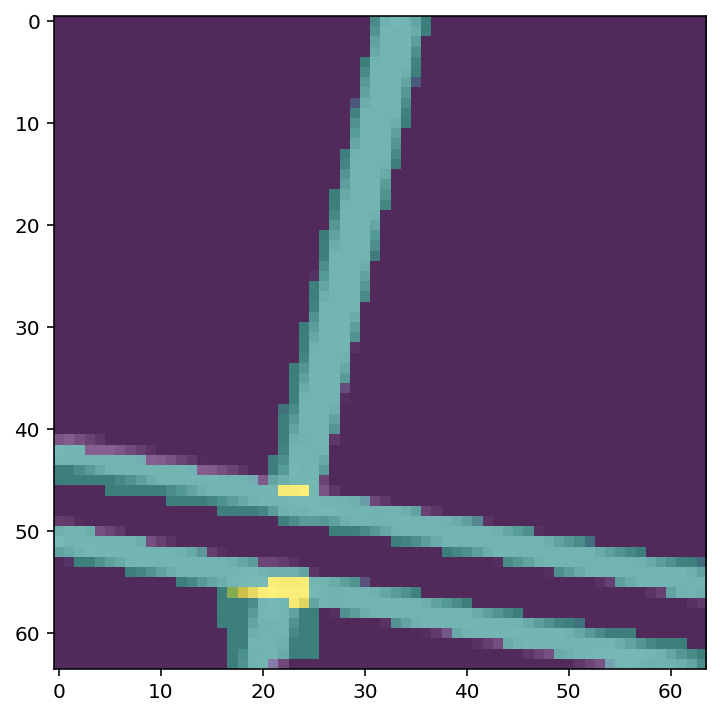

17.895153045654297


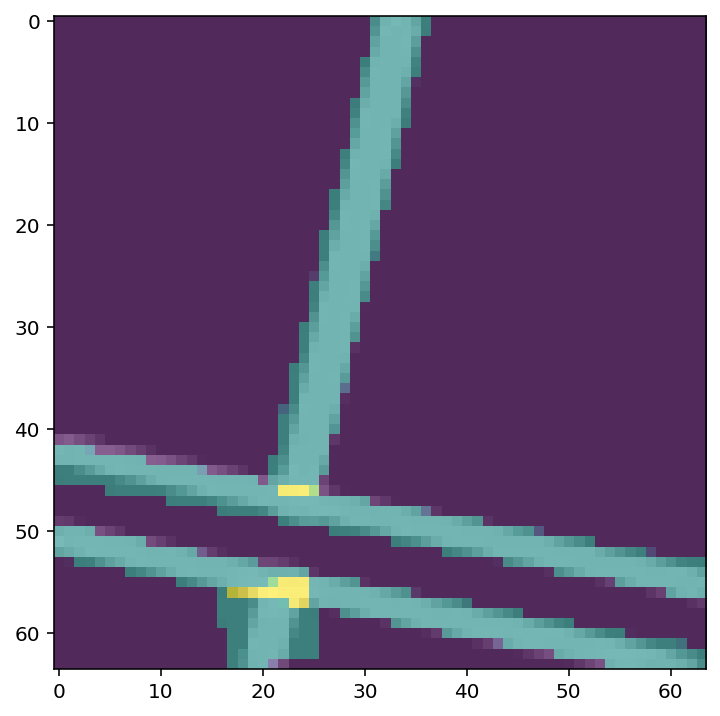

15.780374526977539


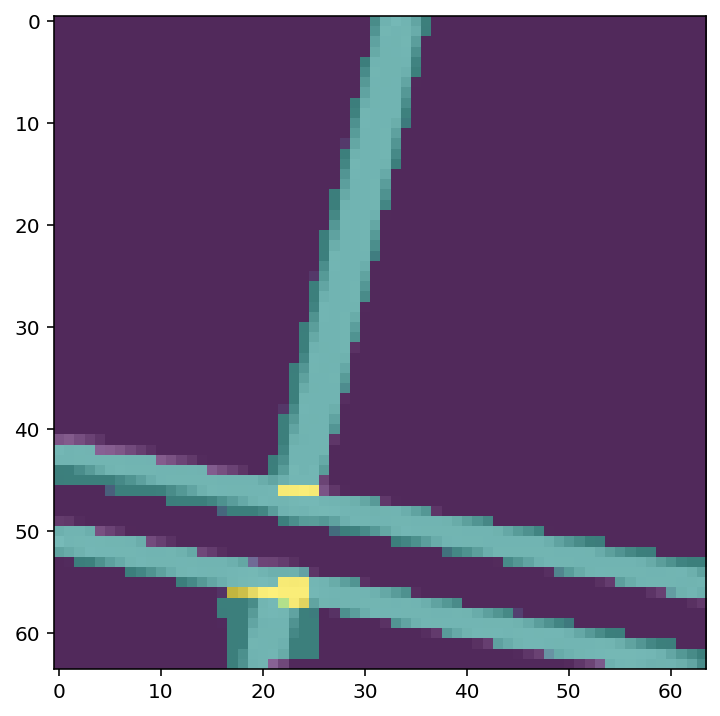

12.809633255004883


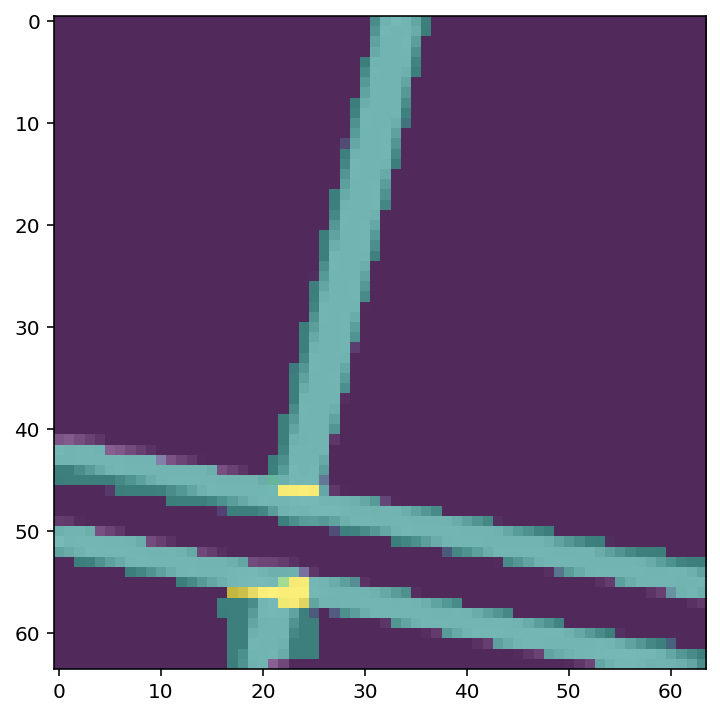

8.267866134643555


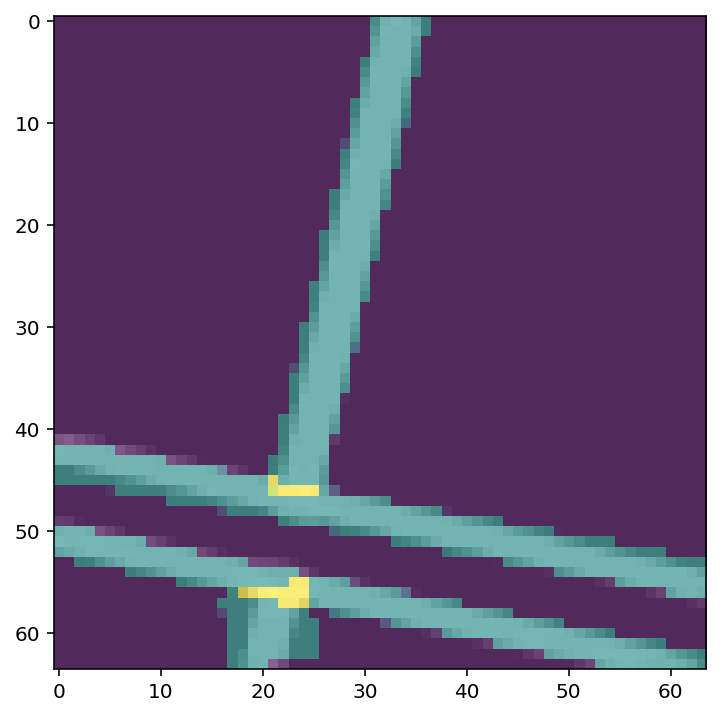

4.602457046508789


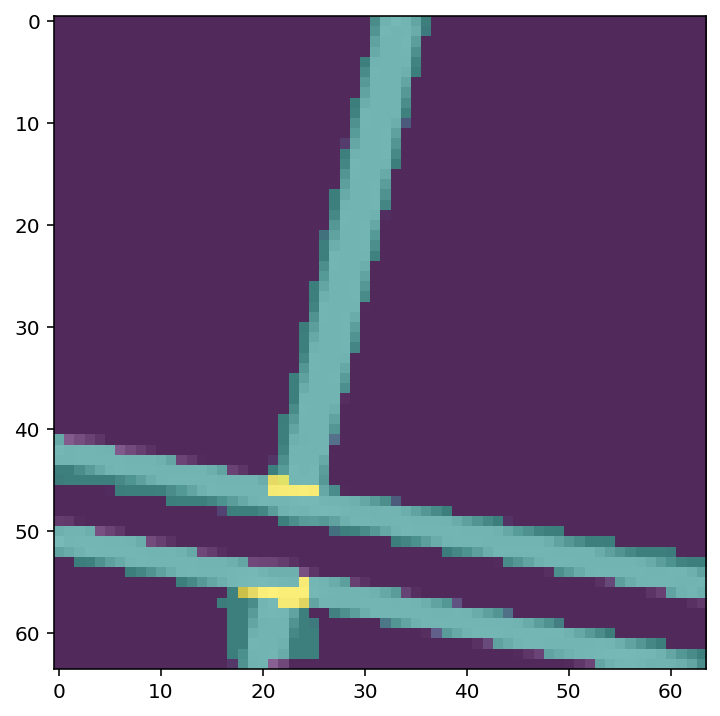

1.4803054332733154


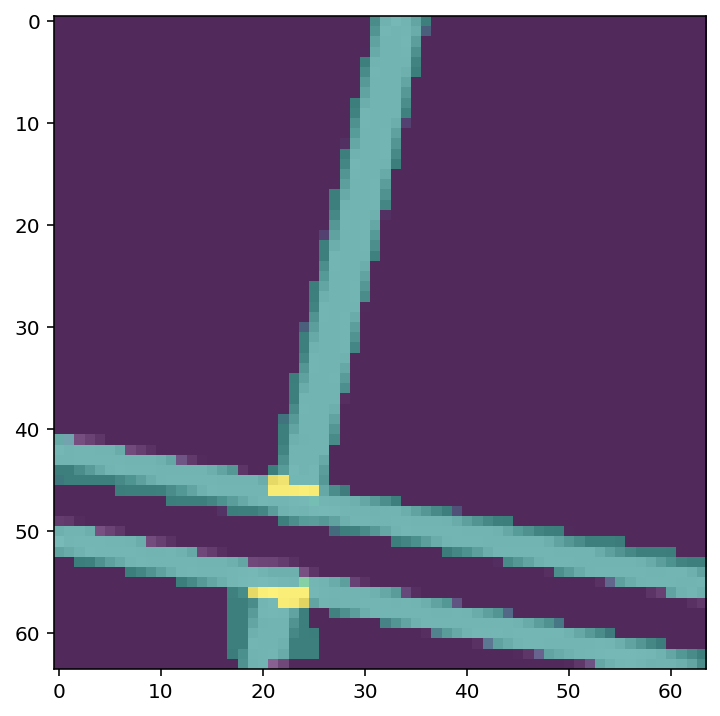

-5.0576982498168945


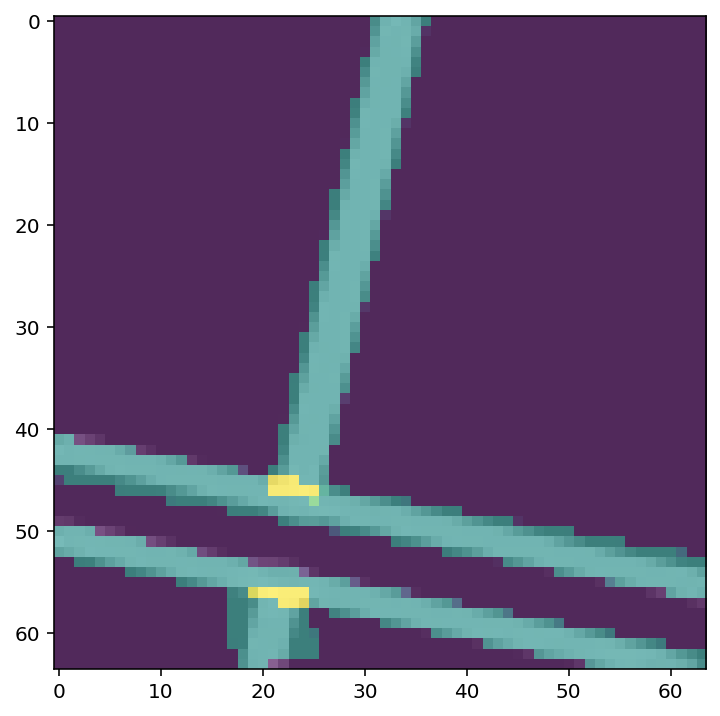

-7.64083194732666


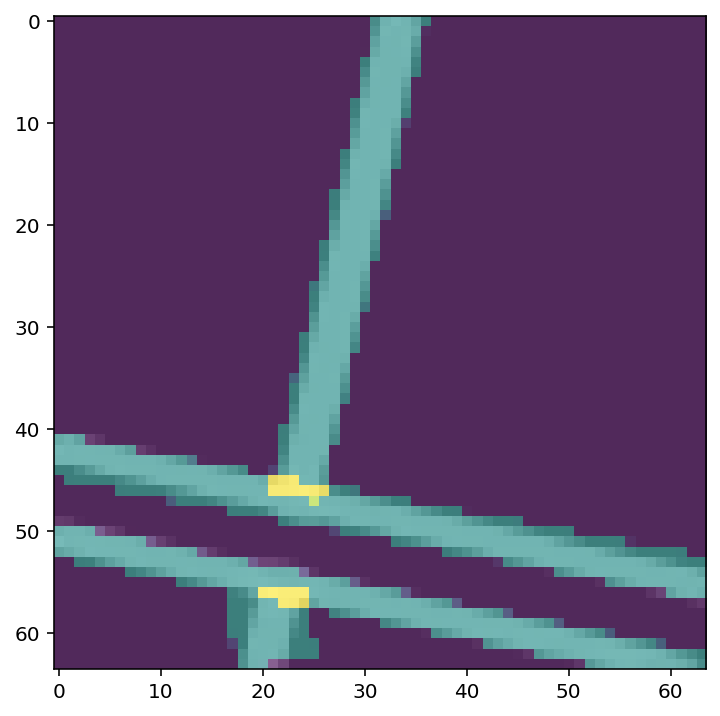

-8.016119956970215


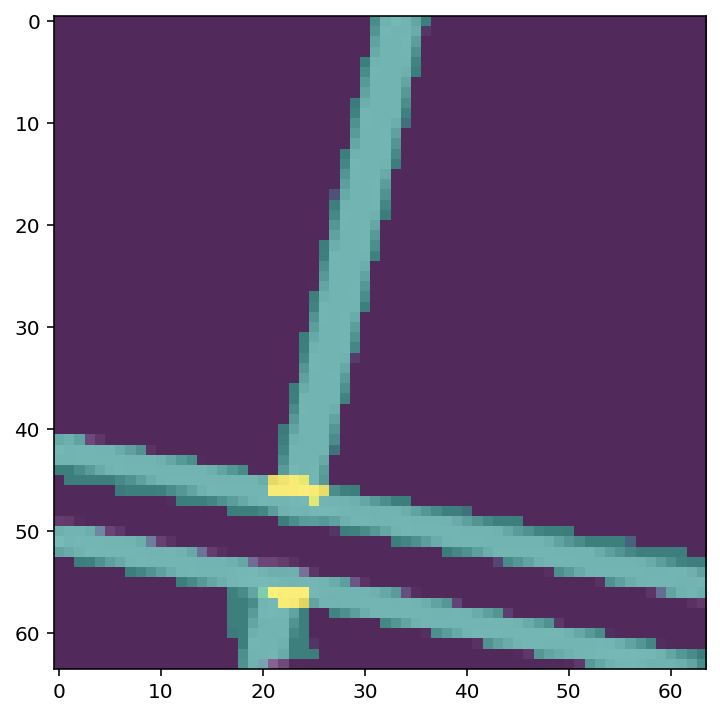

-12.722079277038574


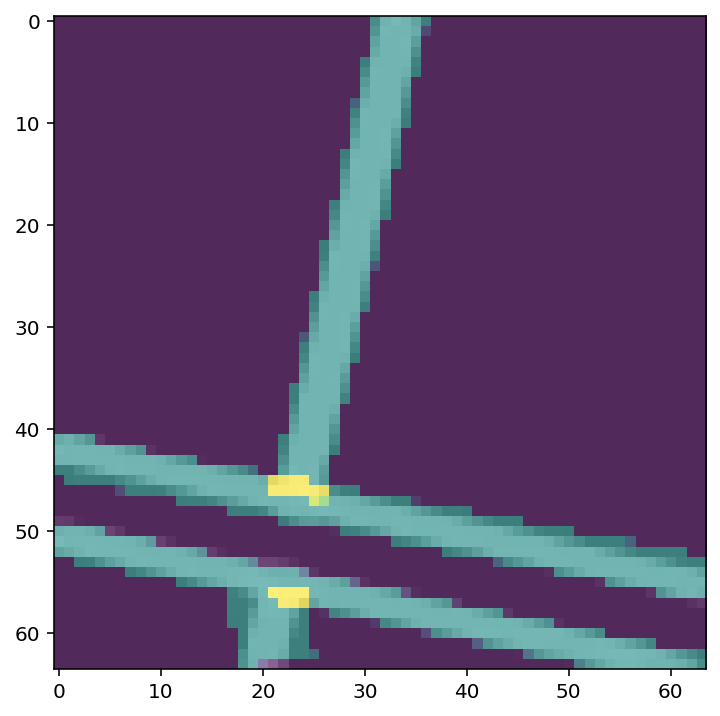

-13.409322738647461


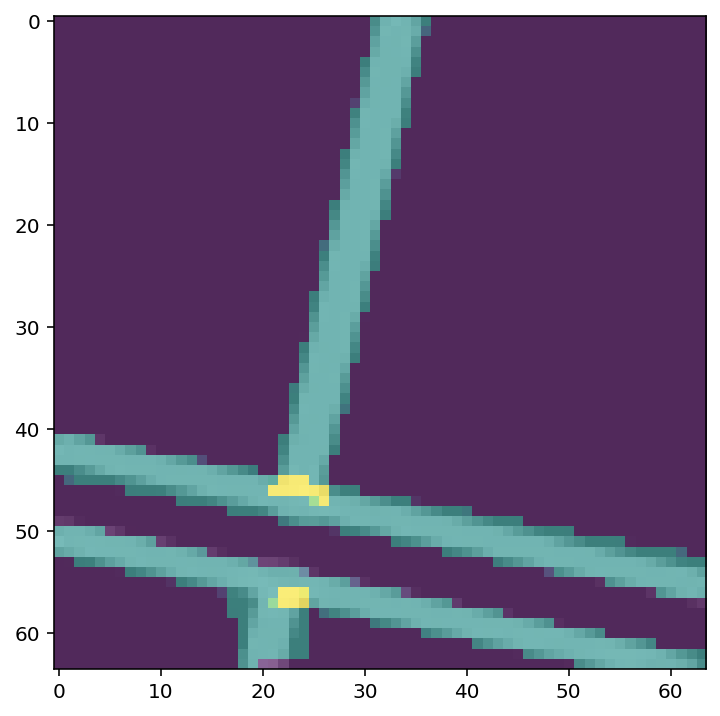

-12.135063171386719


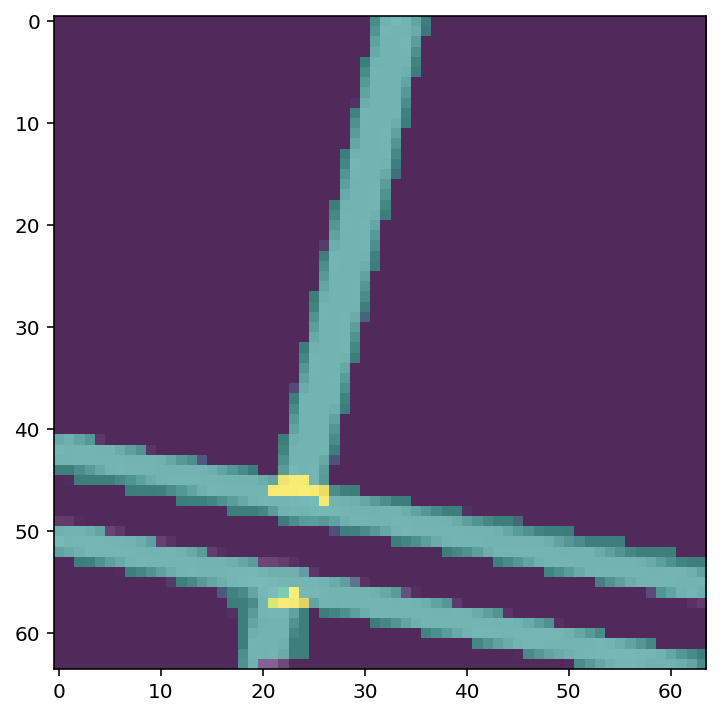

-11.554634094238281


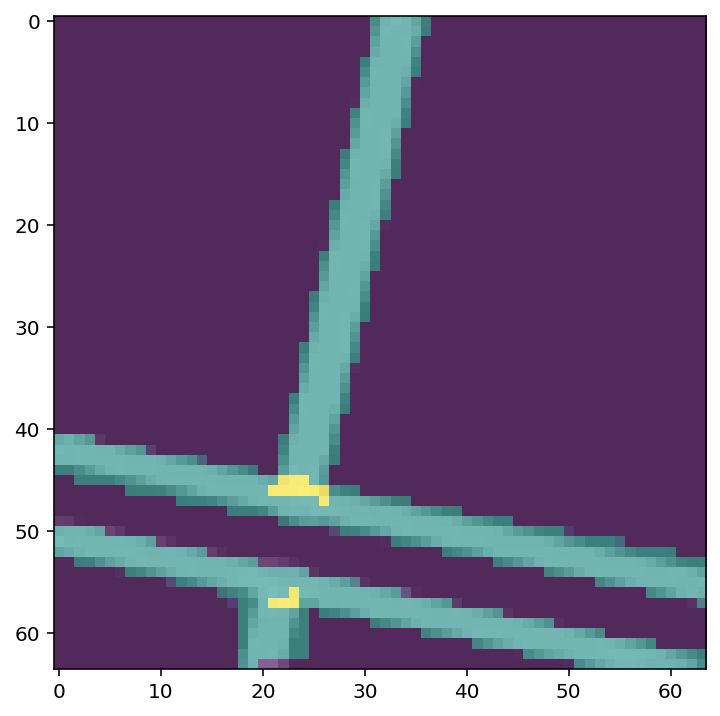

-9.337839126586914


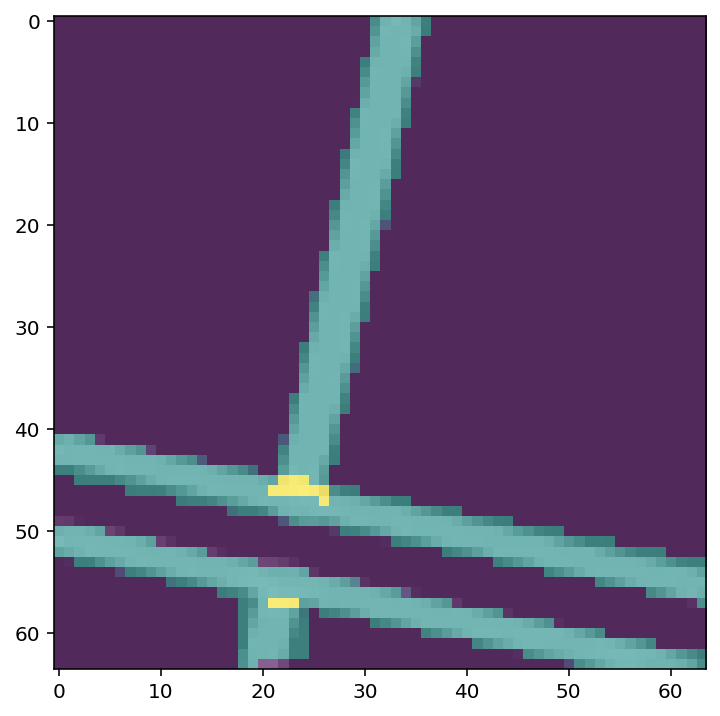

-8.581960678100586


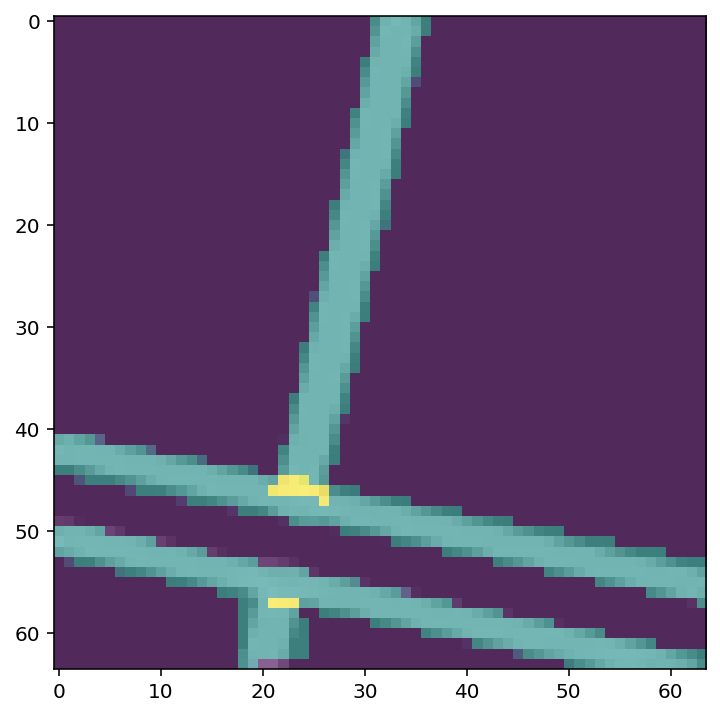

-10.44287395477295


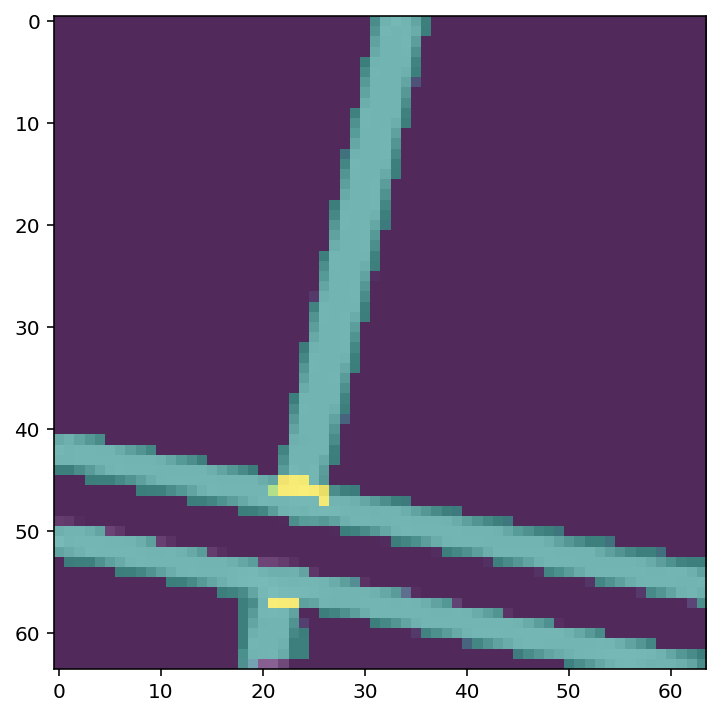

-8.818488121032715


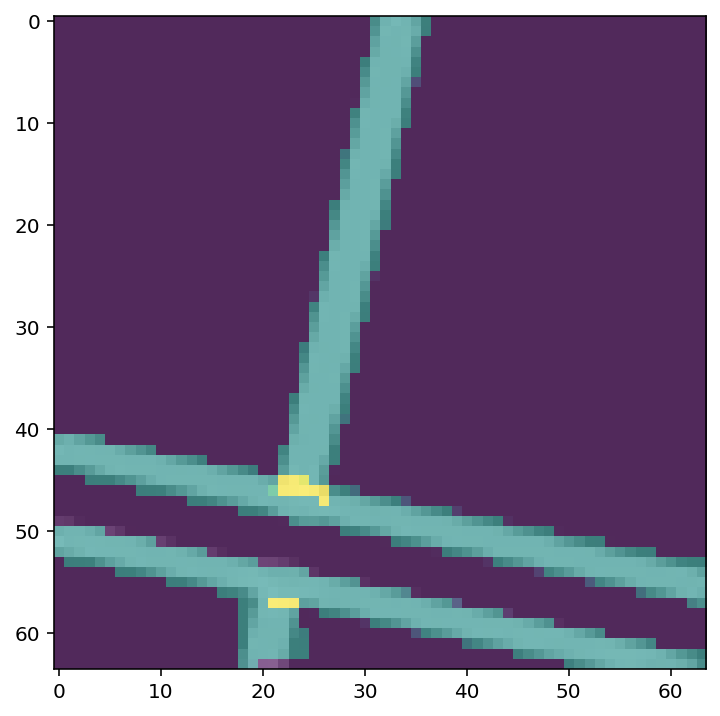

-6.472014904022217


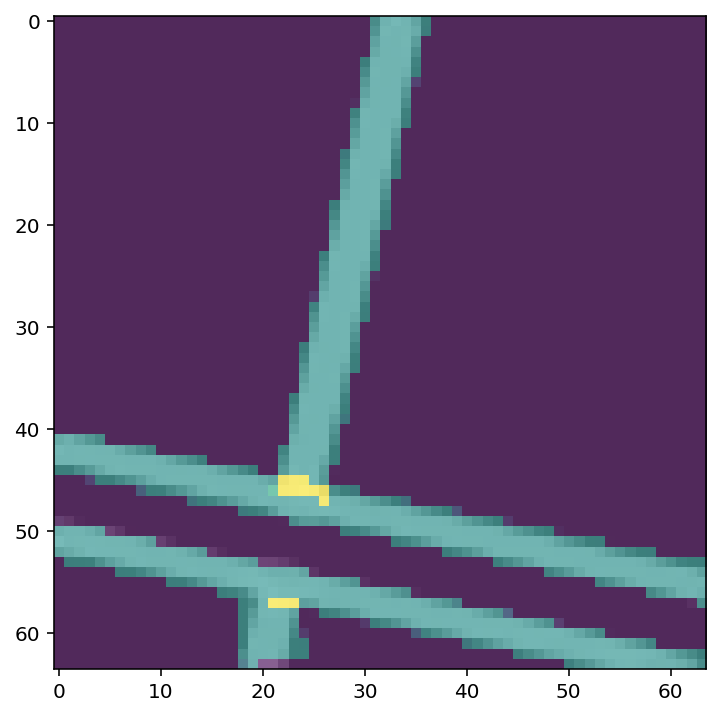

-2.859382152557373


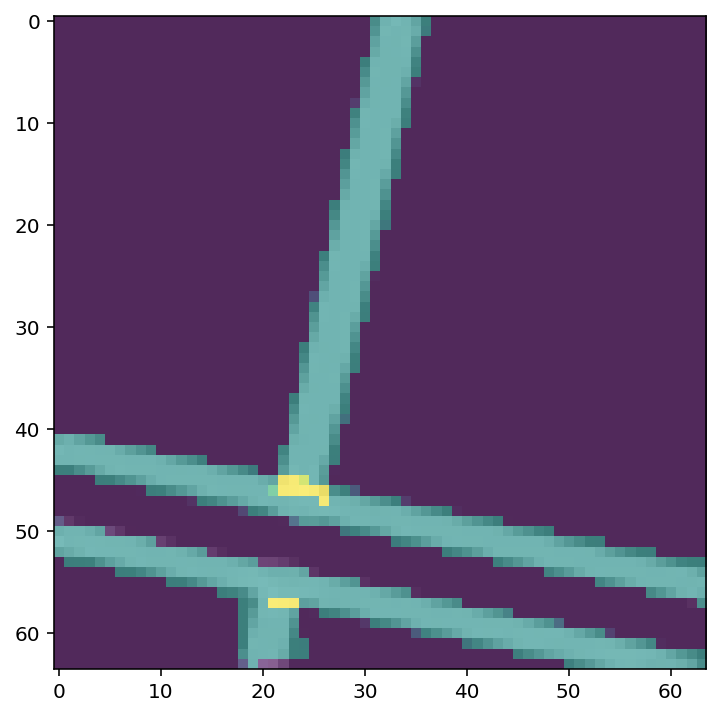

-2.4788777828216553


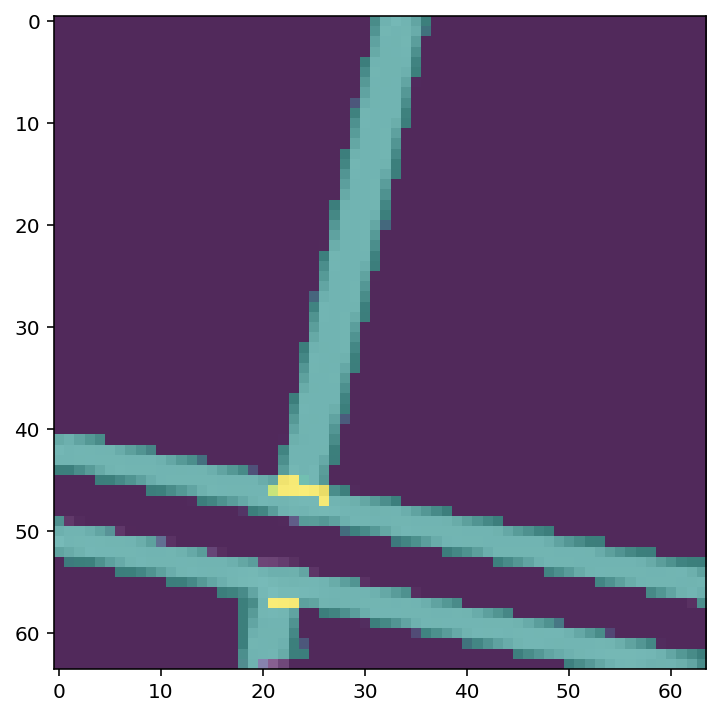

-0.627661943435669


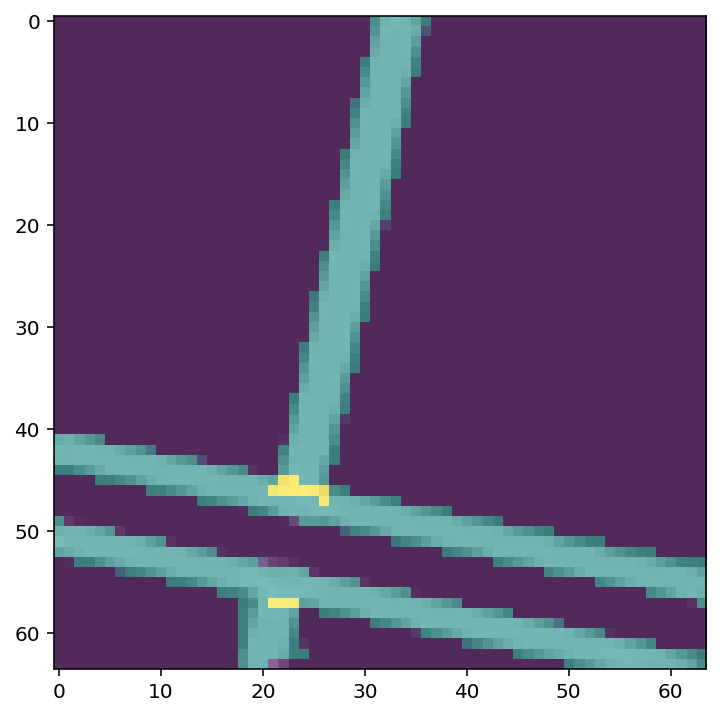

0.7621874809265137


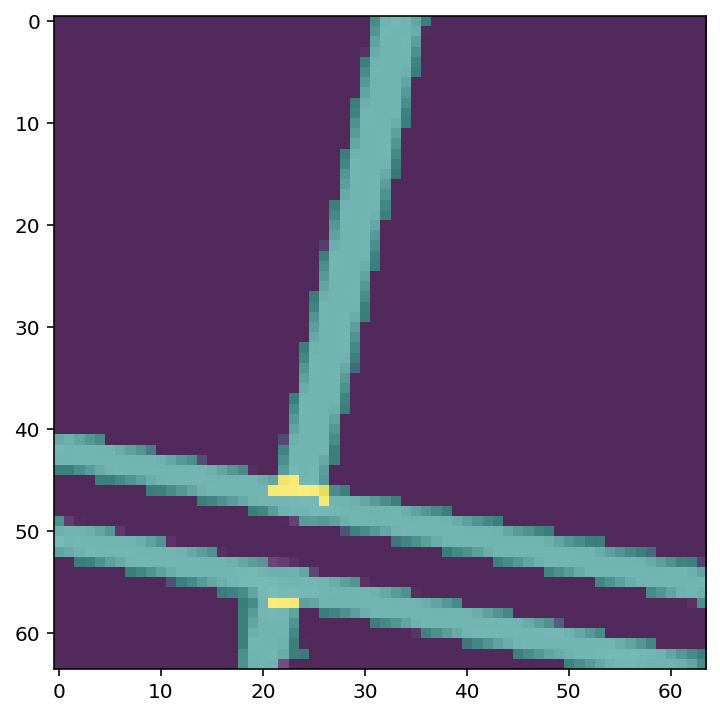

1.6313254833221436


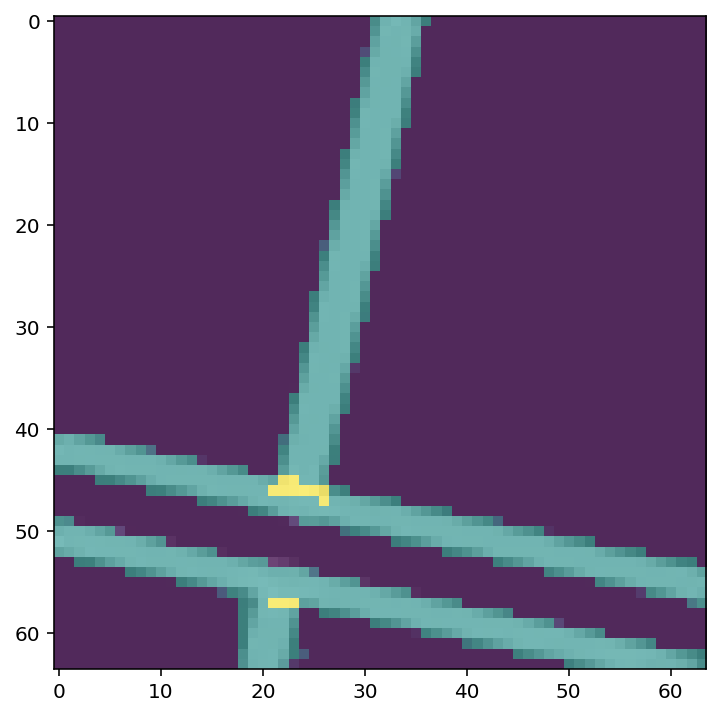

1.2566406726837158


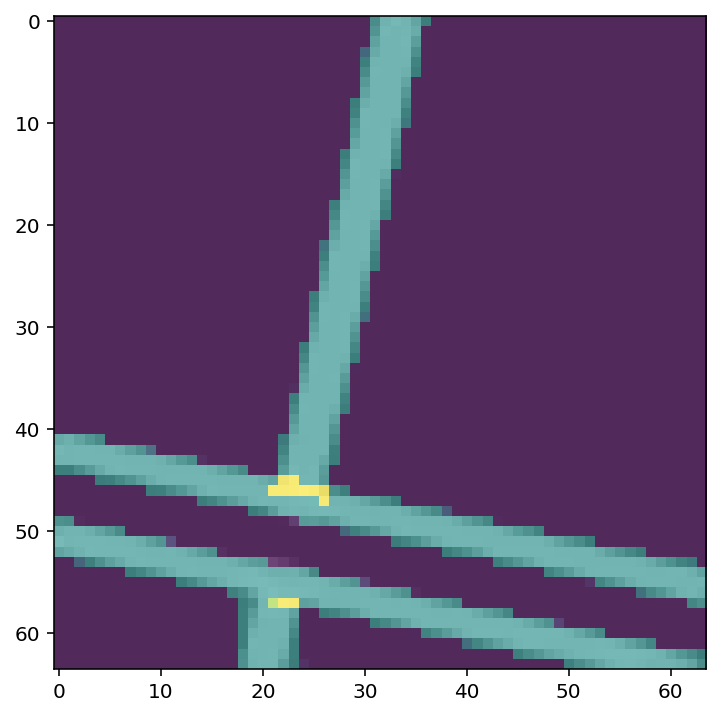

4.5995330810546875


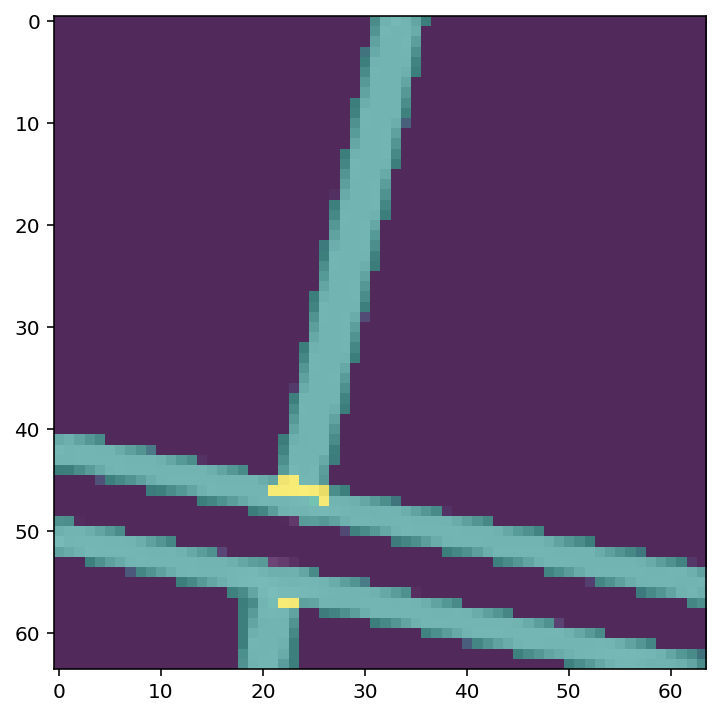

7.311868190765381


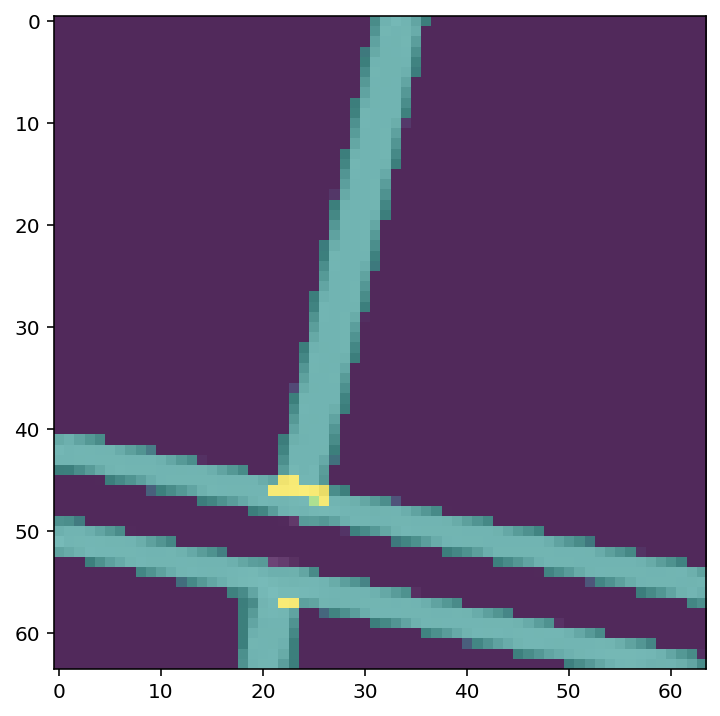

10.238739013671875


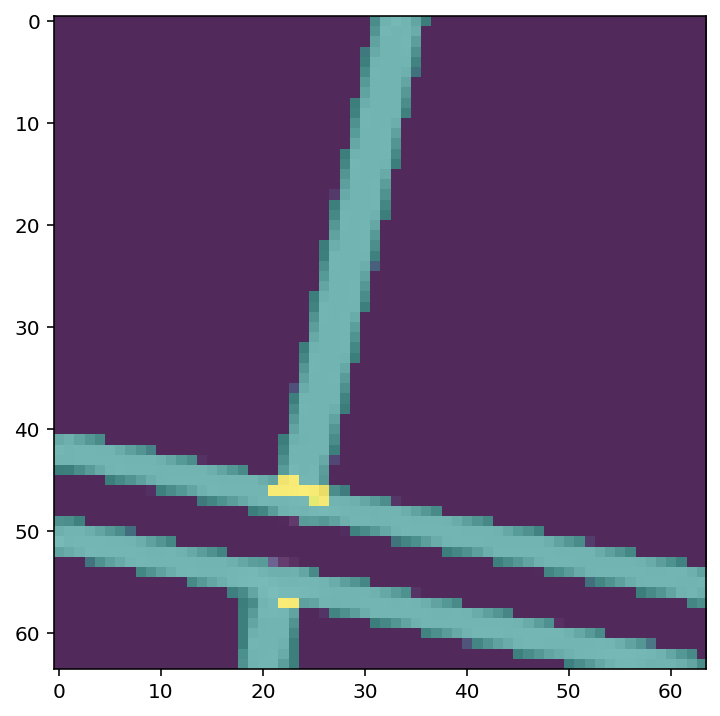

13.498031616210938


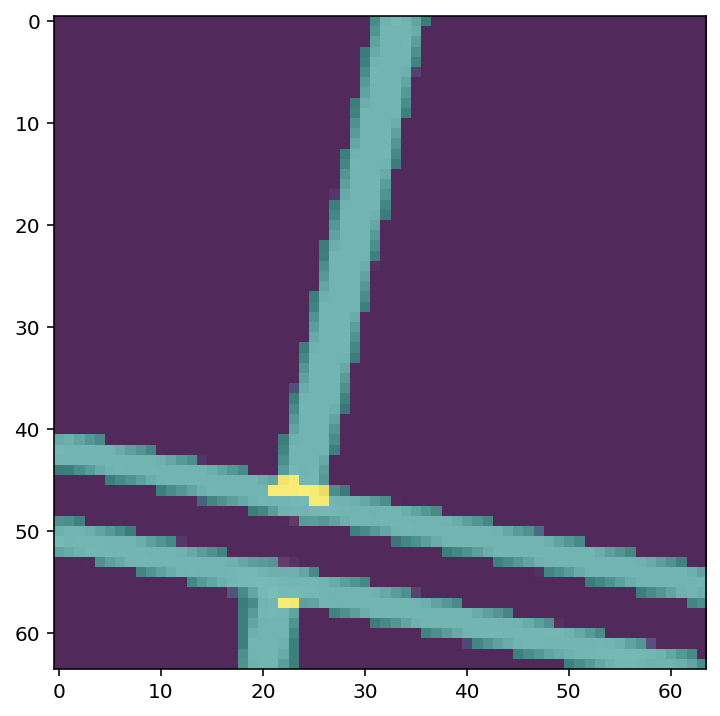

16.00473976135254


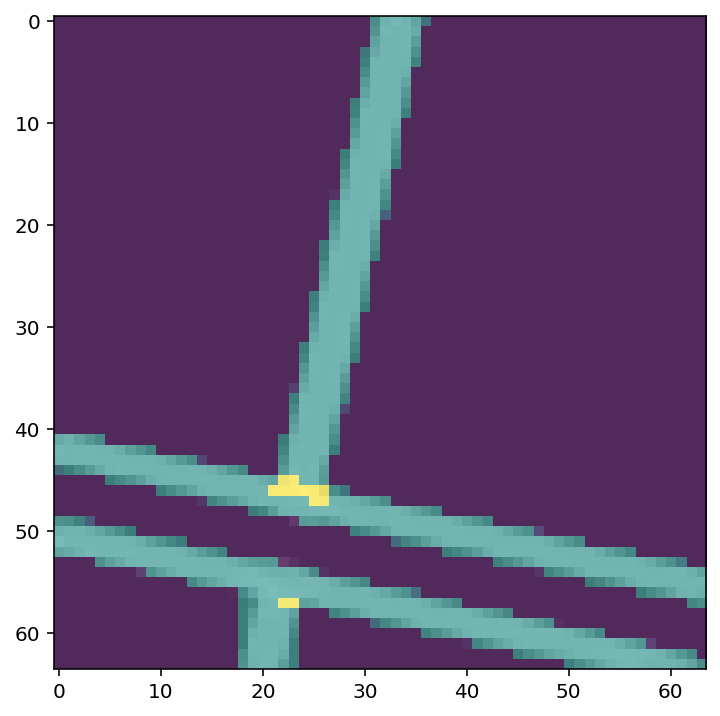

18.788511276245117


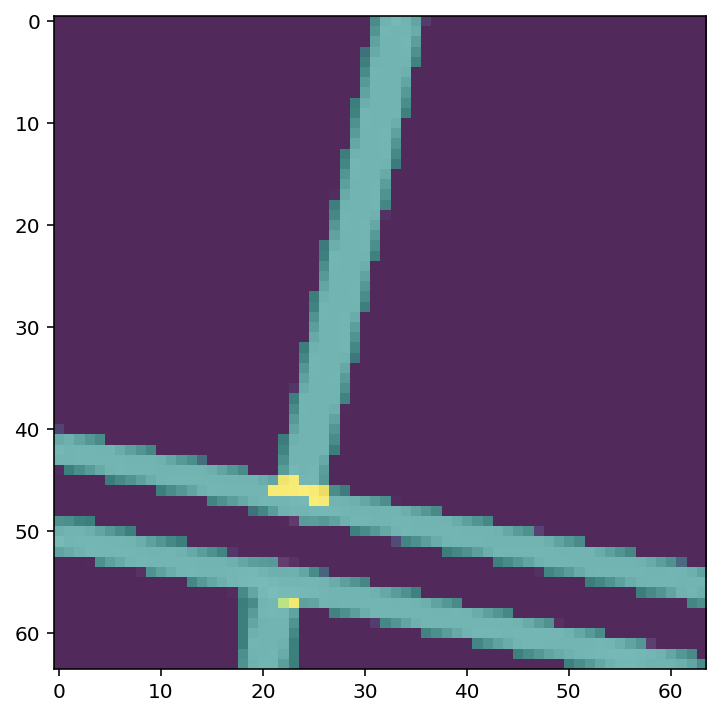

22.74923324584961


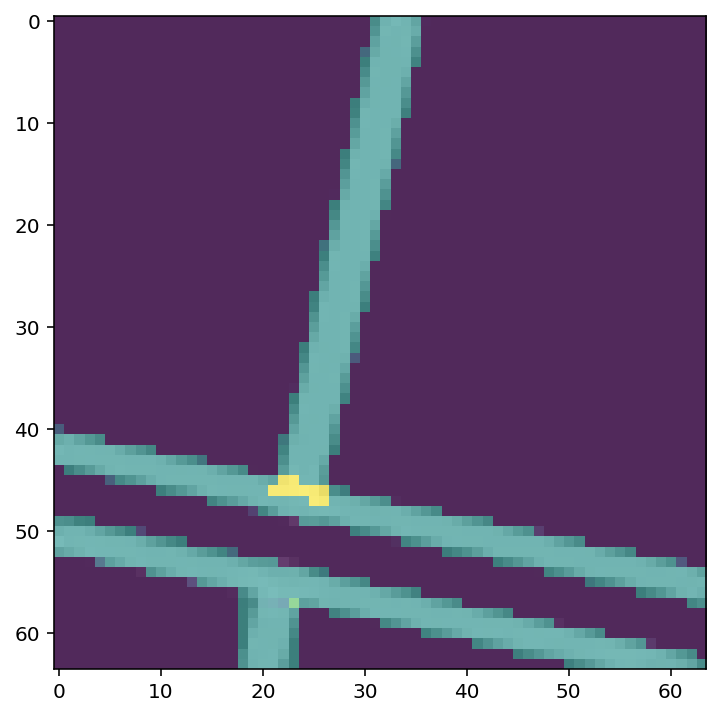

29.822647094726562


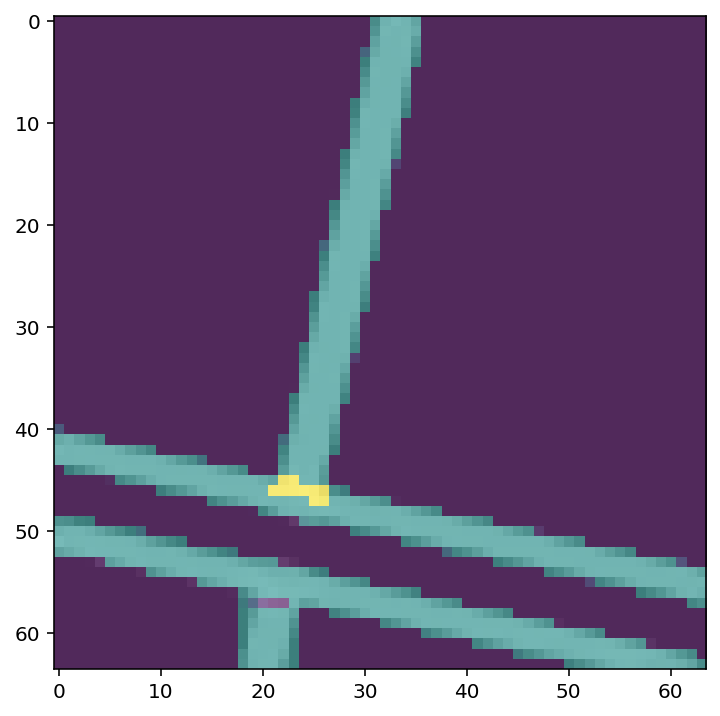

35.75279235839844


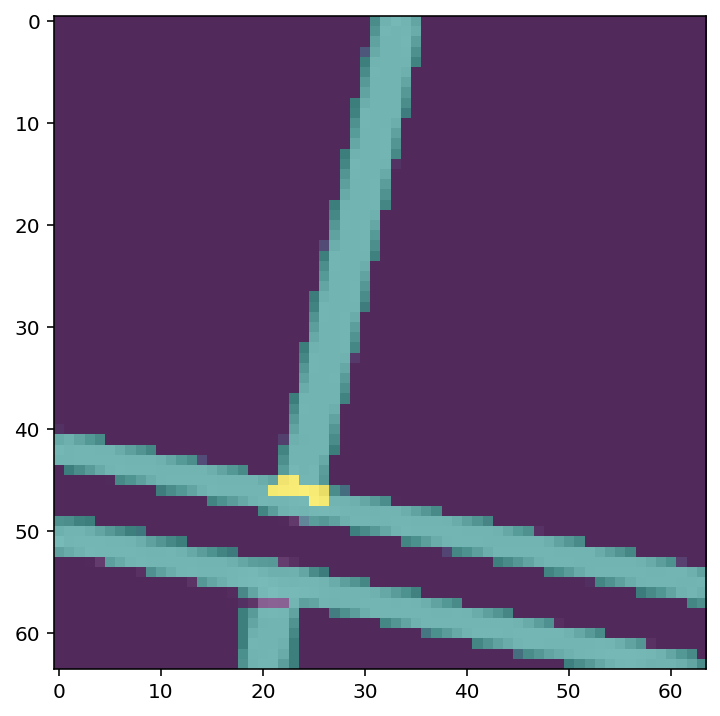

40.85102081298828


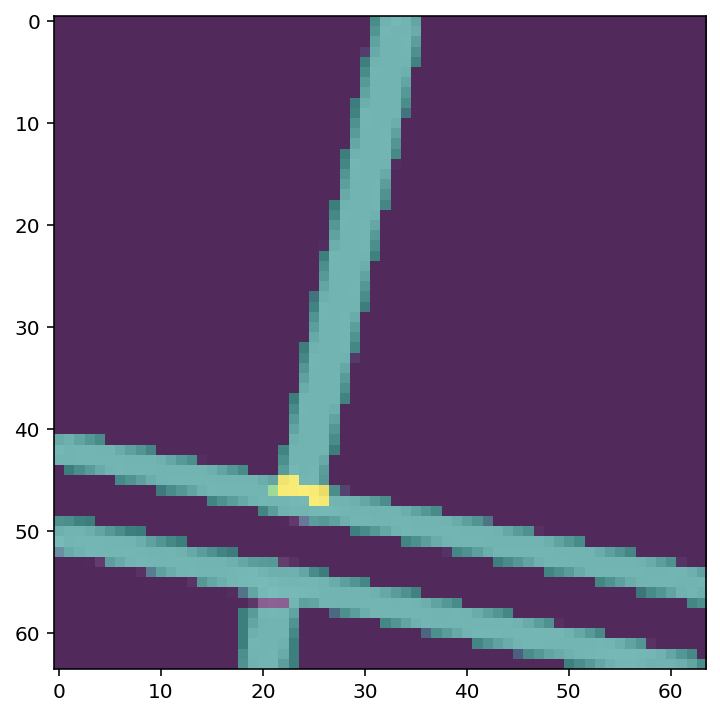

45.35334014892578


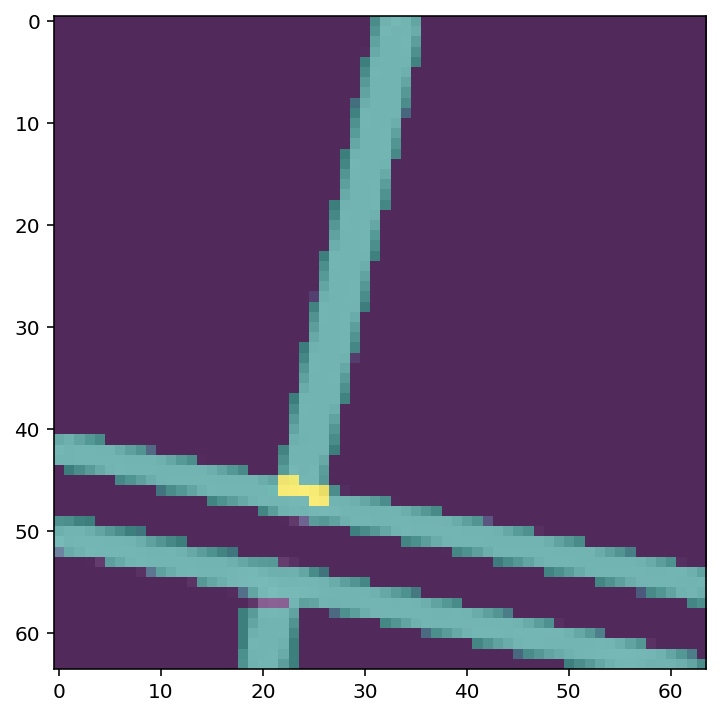

51.21224594116211


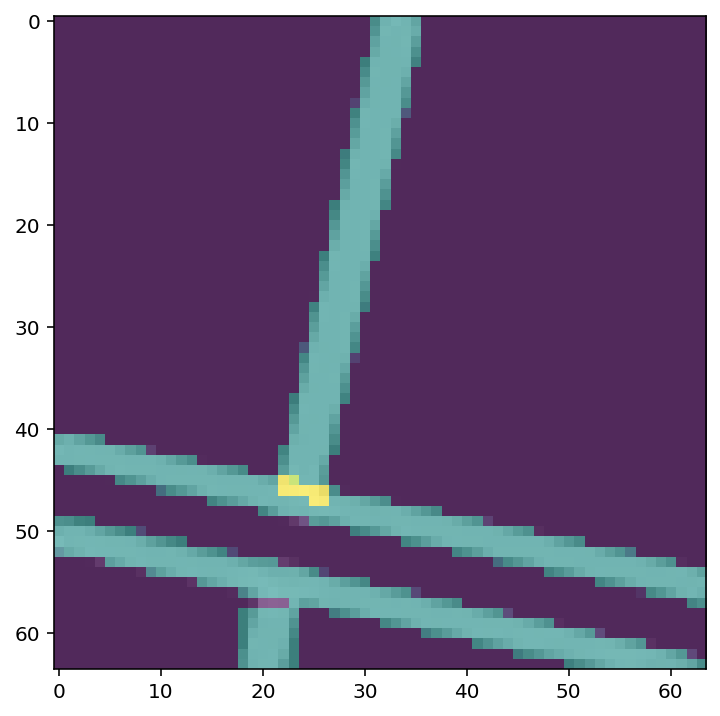

55.20538330078125


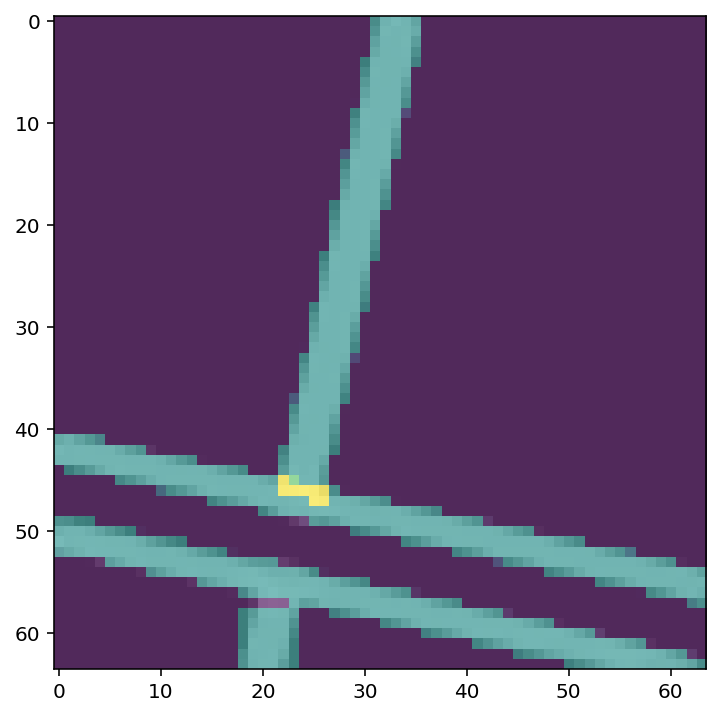

58.4166145324707


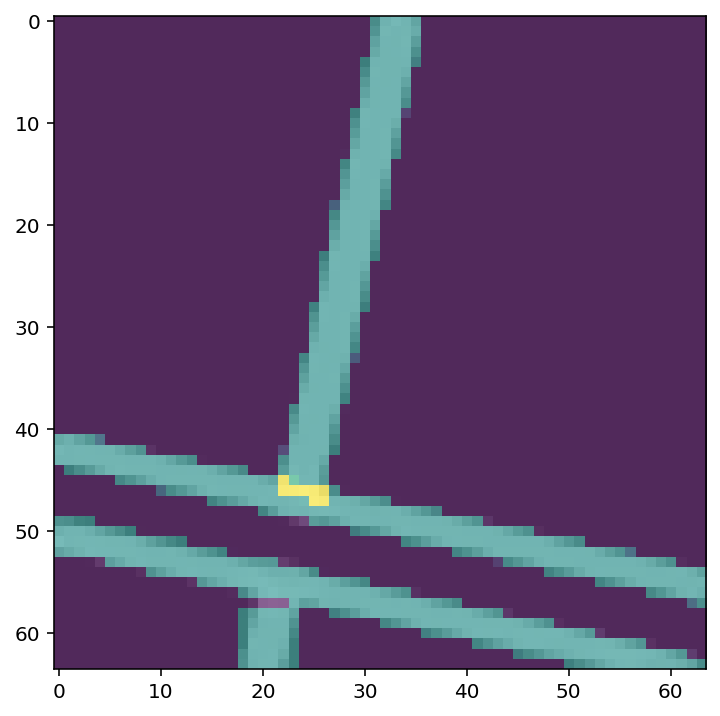

60.50444030761719


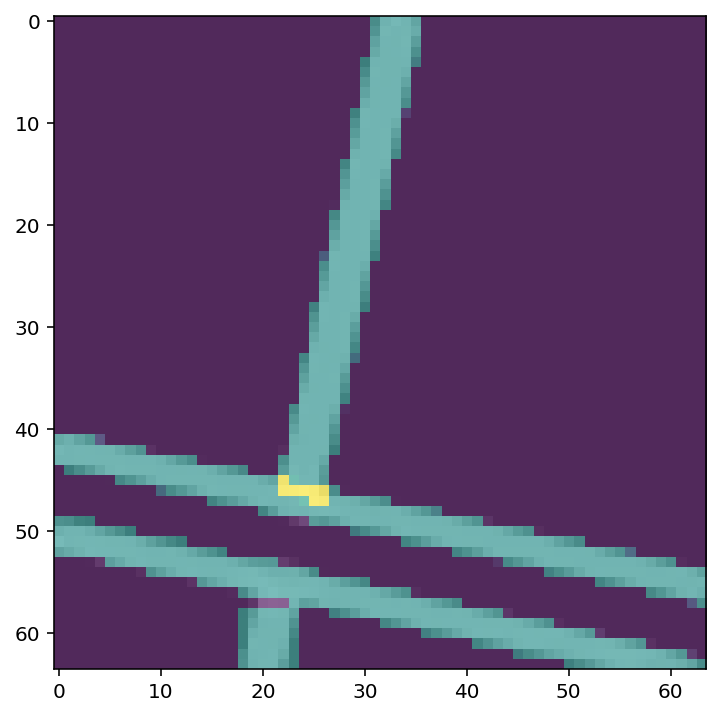

62.10100555419922


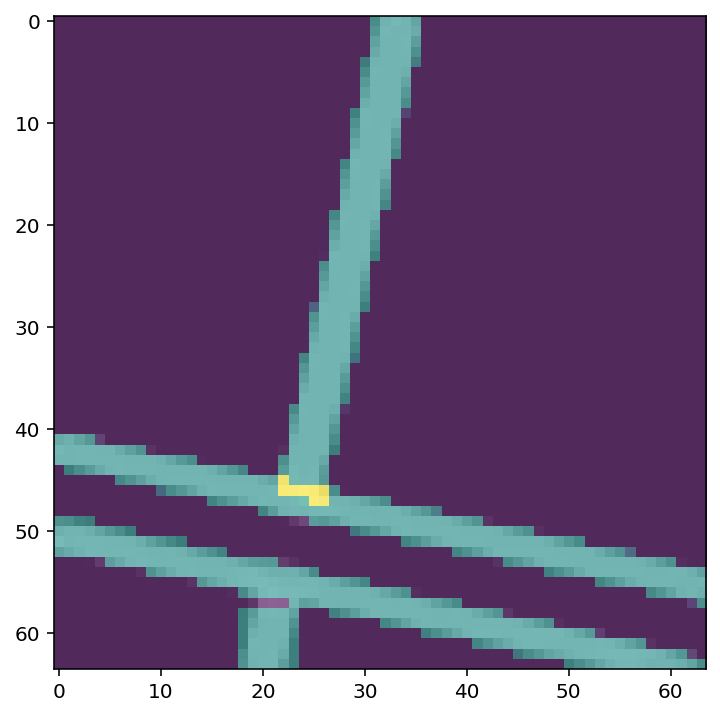

63.71586608886719


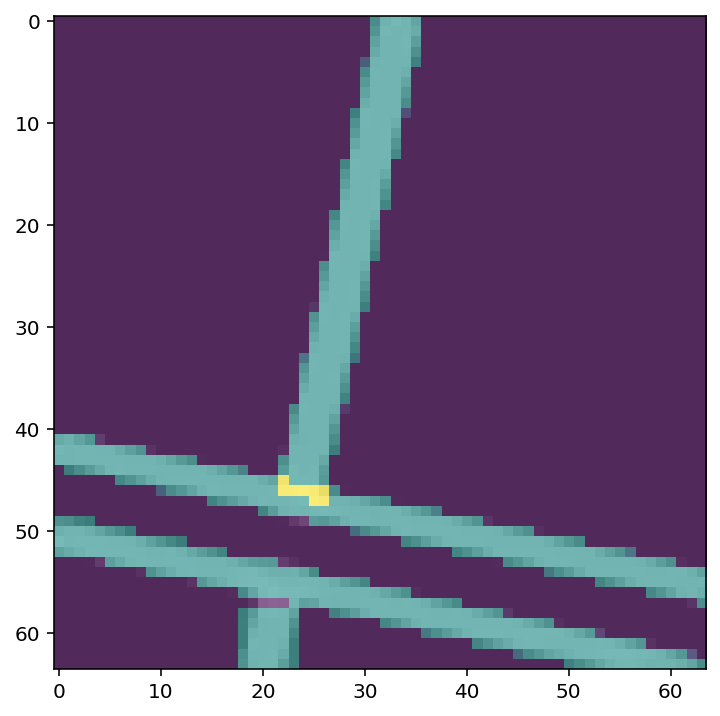

65.93058013916016


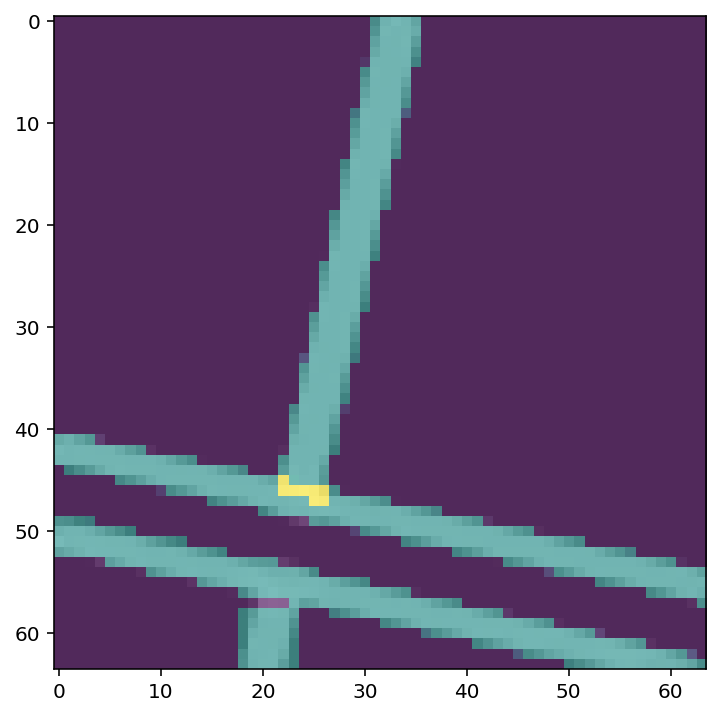

67.64950561523438


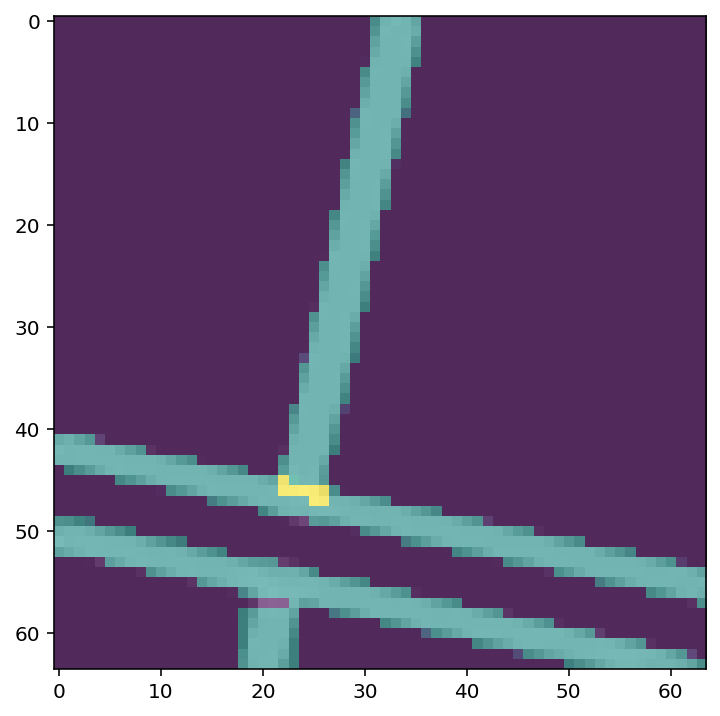

69.84938049316406


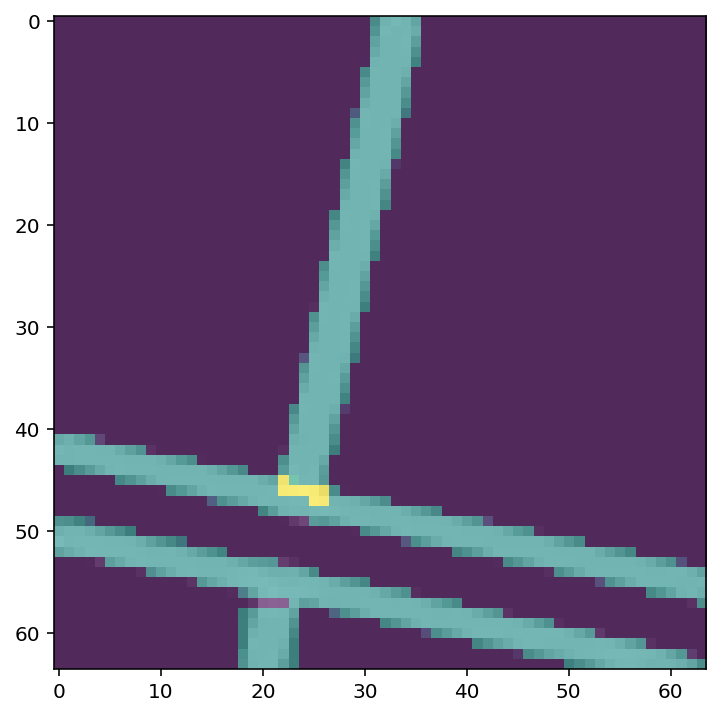

72.02548217773438


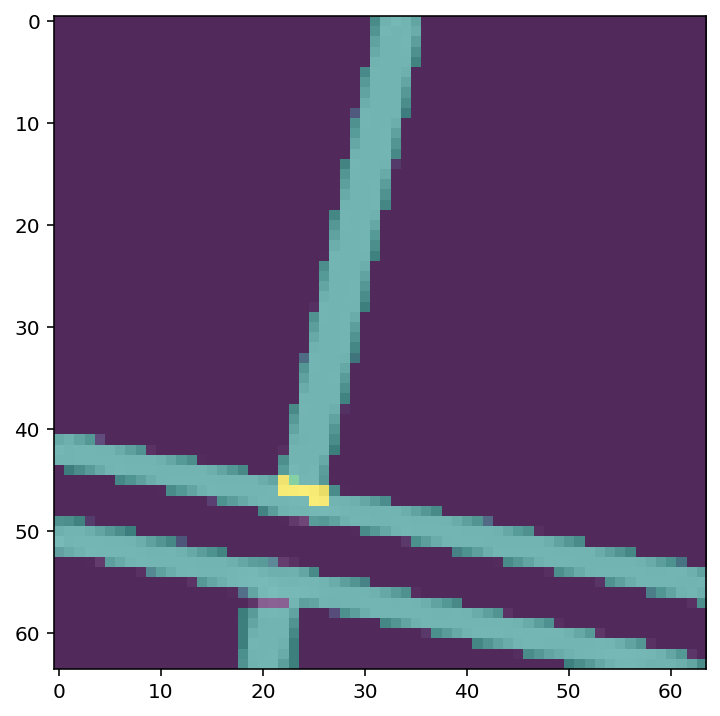

74.68844604492188


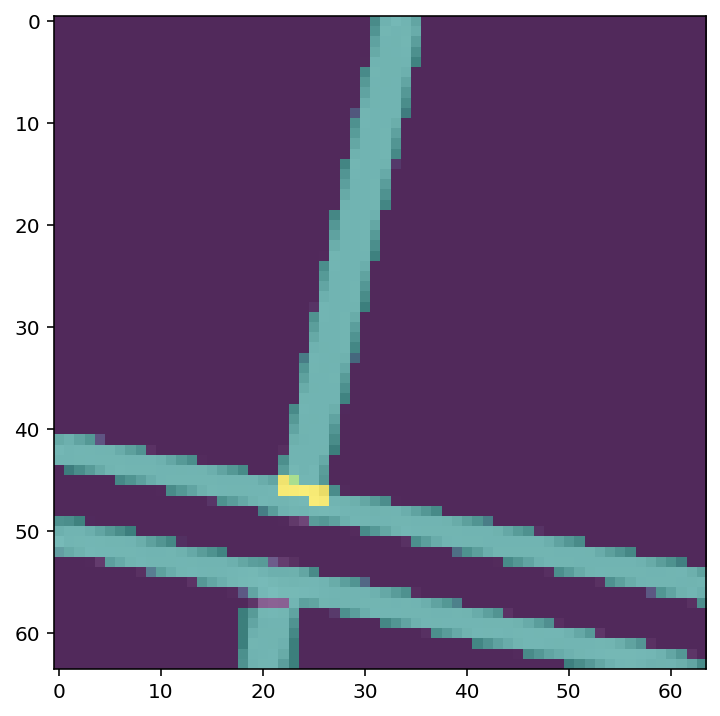

76.65711975097656


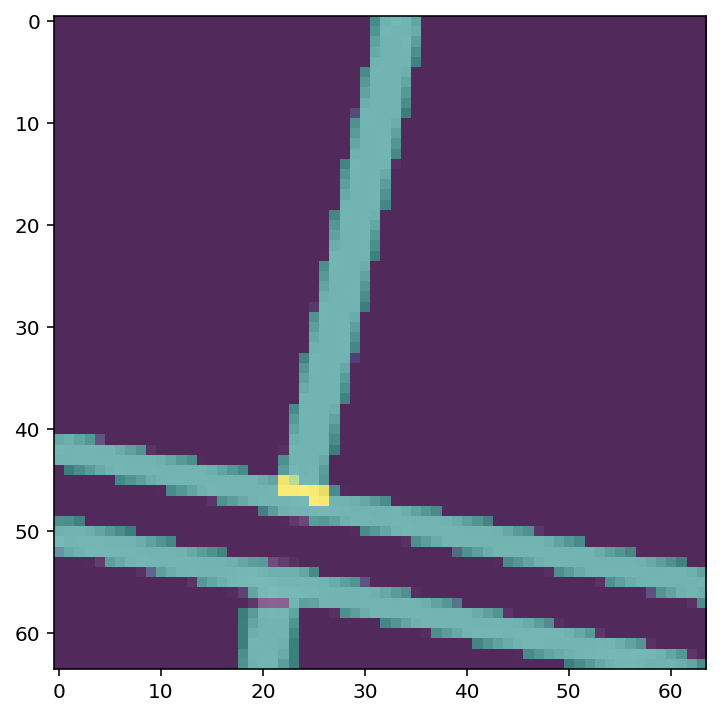

77.35889434814453


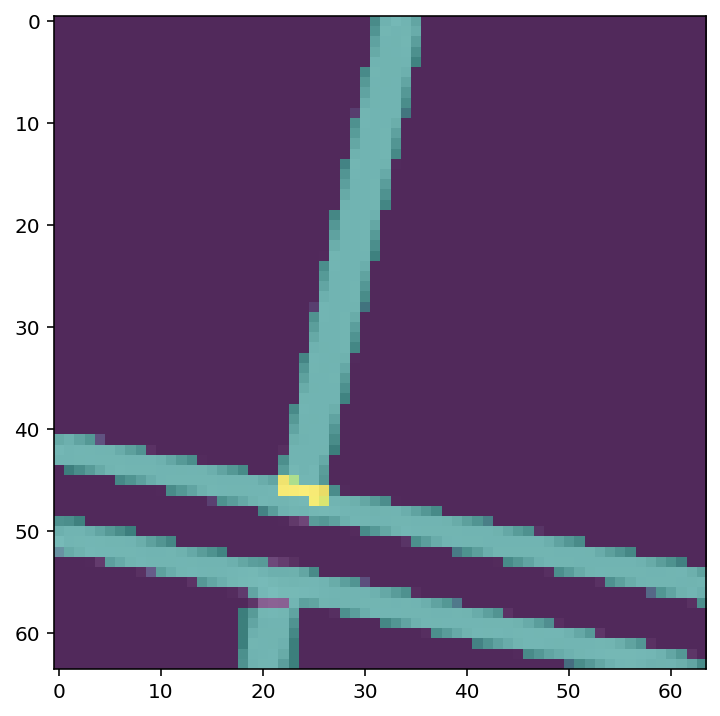

78.2364730834961


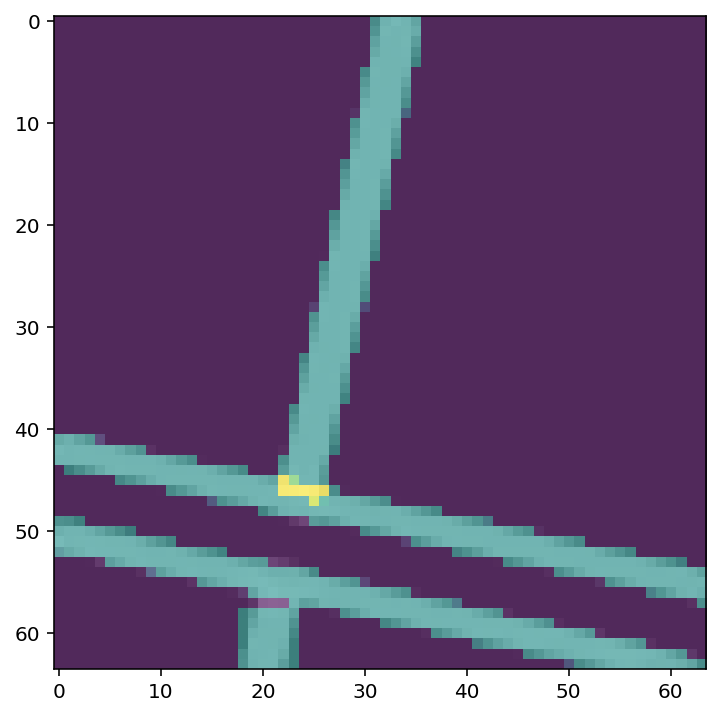

78.8912124633789


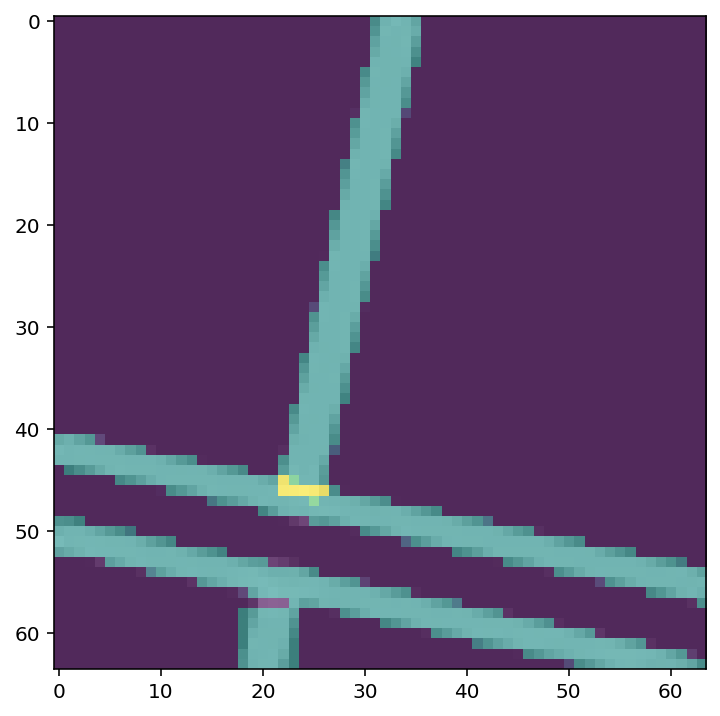

79.89784240722656


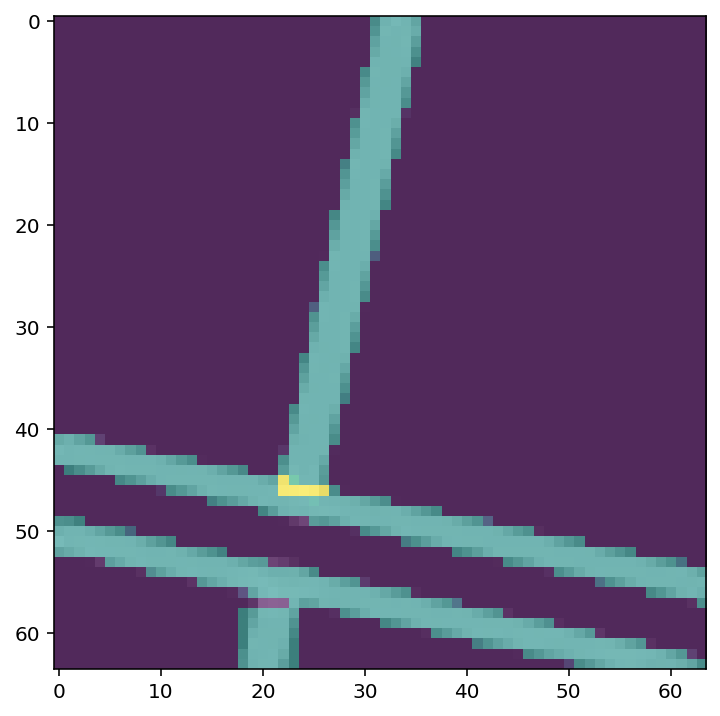

81.35015869140625


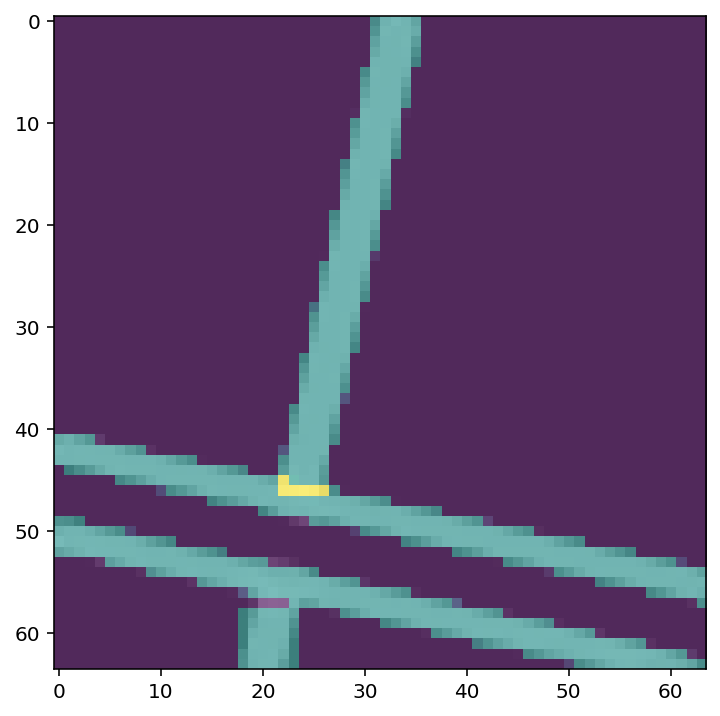

82.22064971923828


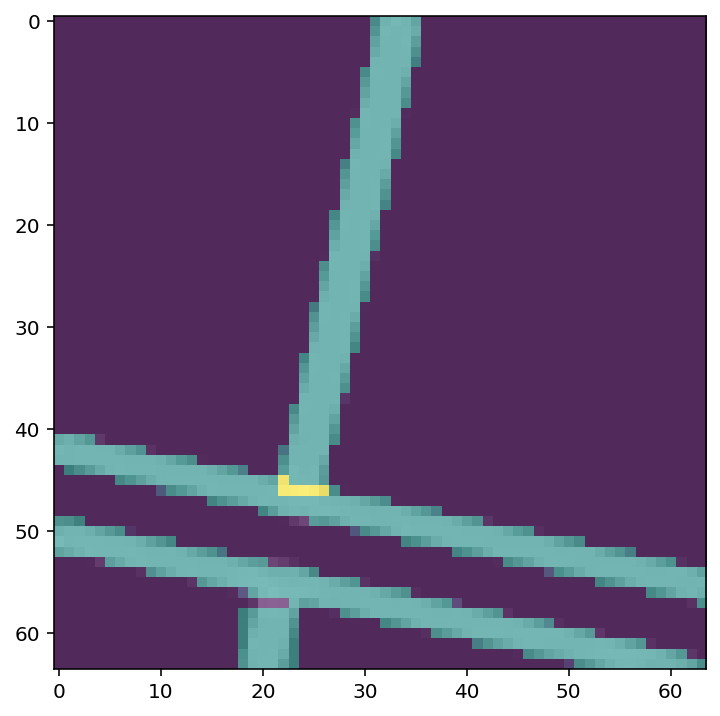

83.4767837524414


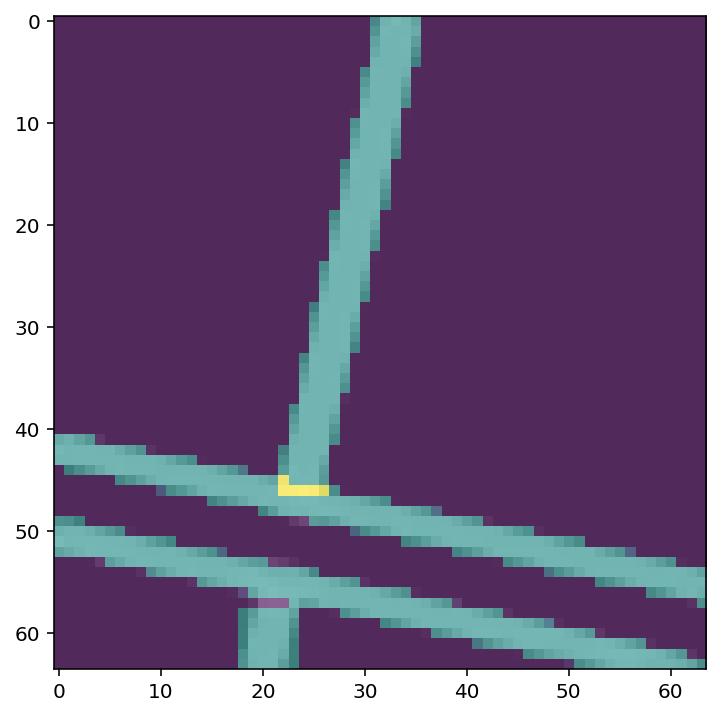

85.09207916259766


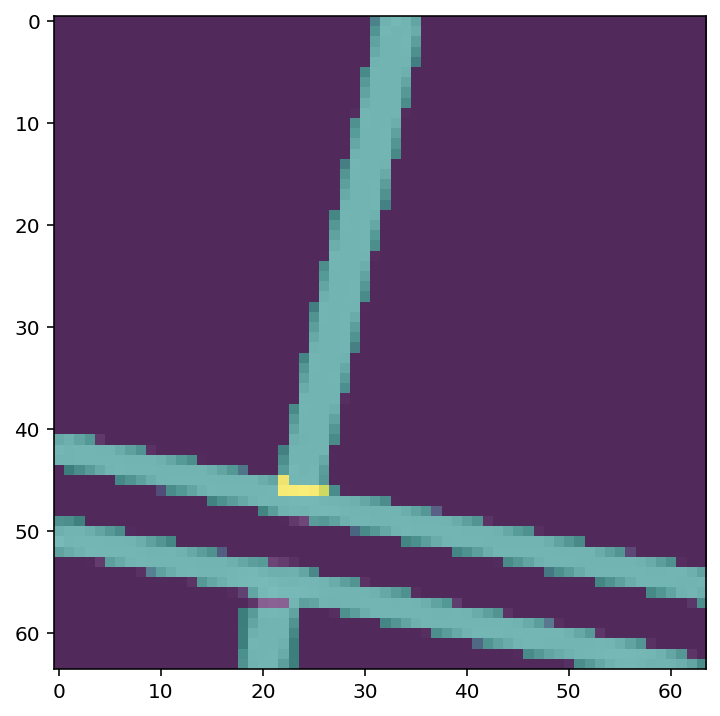

86.53113555908203


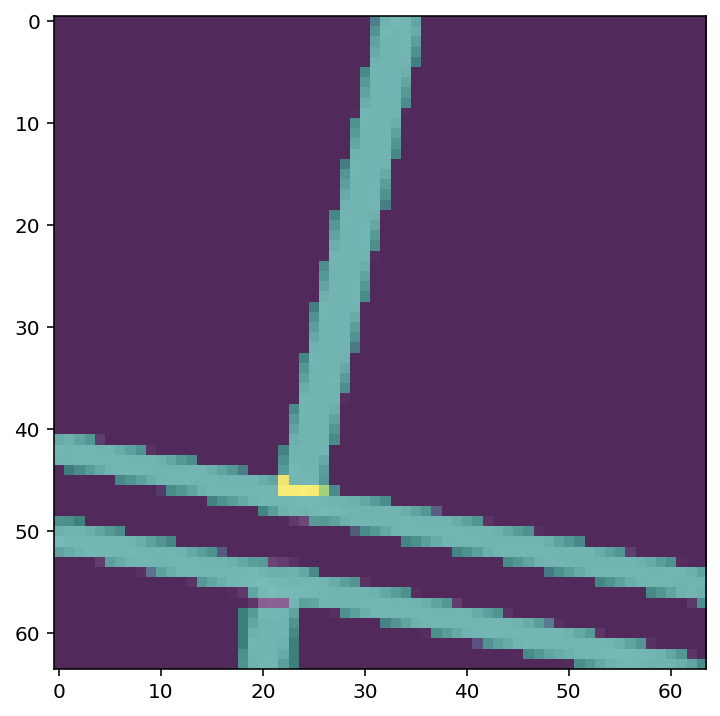

87.67976379394531


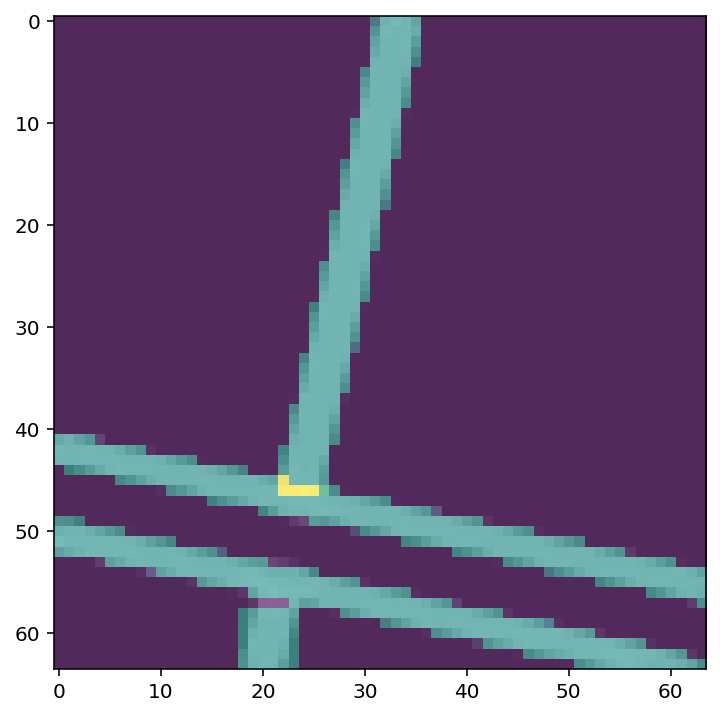

88.54554748535156


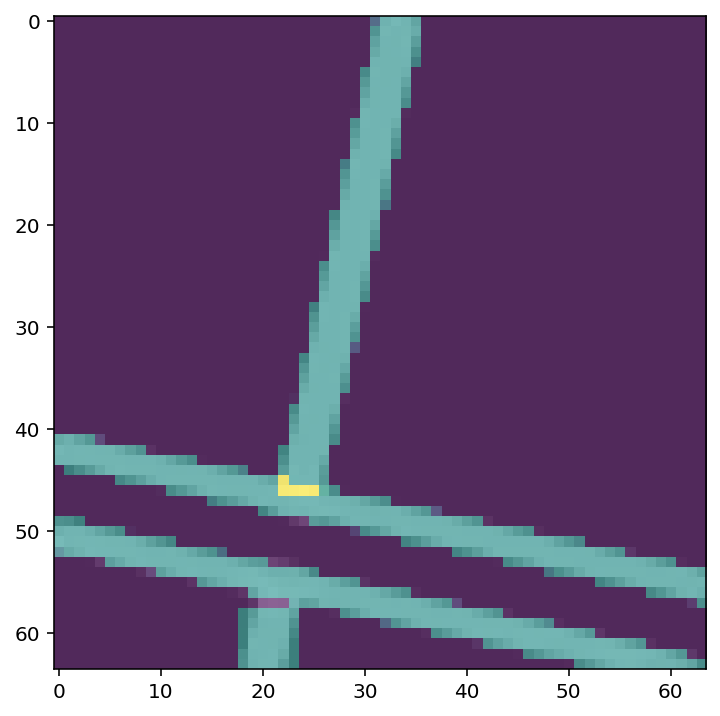

In [25]:
np.random.seed(6)

def transform_synthetic_sample(sample):
    vectors = sample['vector'][PrimitiveType.PT_LINE]
    vectors = vectors[vectors.sum(axis=1) != 0][:, :5]

    perturbed_lines = perturber.transform(vectors)
    perturbed_batch = wrap_lines_into_numpy_batch(perturbed_lines)
    perturbed_batch = torch.from_numpy(perturbed_batch).to(DEVICE)
    
    return {
        'line_batch': perturbed_batch,
        'image': 1 - sample['raster']
    }

perturber = LinePerturbationPipe(
    LineRandomShift((-6, 6), (0, 1)),
#     LineClip(0, 63, 0, 63)  # IMPORTANT
)

model.train(False)

def total_mass_loss(state):
    return 2 * (state['raster'].sum() - state['render'].sum())
    

loss = LossComposition()
loss.add(make_default_loss_fn(bce_schedule=(lambda state: 5.0)))
loss.add(total_mass_loss)

for random_seed in range(1):
    sample = transform_synthetic_sample(syn_dataset[random_seed])
    image = sample['image']
    image = torch.from_numpy(image).unsqueeze(dim=0).unsqueeze(dim=1)
    image = model.forward(image.to(DEVICE)).detach().cpu().numpy()[0][0]
    line_batch = sample['line_batch']
    
    aligner = make_simple_aligner(line_batch, image, loss_fn=loss)
    aligner.add_after_step_callback(store_render_difference)
    aligner.add_after_step_callback(save_best_batch)
    
    for _ in range(100):
        aligner.step()
        raster = aligner.state['raster'].detach().cpu().numpy()
        render = aligner.state['render'].detach().cpu().numpy()
        print(aligner.state['loss_value'].item())
        plt.figure(figsize=(6, 6))
        plt.imshow(raster, cmap='gray', alpha=0.6)
        plt.imshow(render, alpha=0.6)
        plt.show()

##### 